### Code for classifying, segmenting–and largely failing to find any interesting sub-variatio within–CSD

In [1]:
## First build dataset: 
import os
import pickle
from pose_class import Trajectory
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

import pandas as pd
from scipy.spatial.distance import pdist,squareform
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

from scipy.stats import mode
from scipy.stats import f_oneway,chisquare
from scipy.stats import gaussian_kde
from scipy.stats import zscore


from statsmodels.stats.multicomp import pairwise_tukeyhsd

from scipy.spatial.distance import squareform
import umap

In [2]:
## For reference:
coco_keypoints = {
    0:'beak',
    1:'left_eye',
    2:'right_eye',
    3:'nape',
    4:'neck',
    5:'crown',
    6:'back',
    7:'left_wing',
    8:'right_wing',
    9:'breast',
    10:'tail',
    11:'left_leg',
    12:'right_leg',
    13:'tail_tip',
    14:'empty1',
    15:'empty2',
    16:'empty3'
}
nice_order = [0,1,2,3,4,5,6,7,8,9,11,12,10,13]
coco_keypoint_list = list(coco_keypoints.values())[:14]

In [3]:
playback_df = pd.read_csv('/data/birds/postures/presentation_info5.csv',delimiter=',')
posture_df = pd.read_csv('./posture_df2.csv')

potency_2019 = [posture_df[(posture_df['Year'] == 2019) & (posture_df['Song'] == i)].iloc[0]['AvgPotency'] for i in range(10)]
potency_2018 = [posture_df[(posture_df['Year'] == 2018) & (posture_df['Song'] == i)].iloc[0]['AvgPotency'] for i in [0,1,3,9]]

pot_dict_2019 = dict(zip(range(10),potency_2019))
pot_dict_2018 = dict(zip([0,1,3,9],potency_2018))

song_list = ['BDY','BOD','ND','LB','2M','DBR','GRG','WG','LNR','DMG']
song_dict = dict(zip(song_list,range(10)))

seq_dir = './CrapSeqs/'
non_list,csd_list = [],[]
part_list = []
potent_list,weak_list = [],[]
n_bins = 101
data_list = []

BLOCK = True
R_HIGH = 0.7
R_LOW = 0.4
high_list,low_list = [],[]


potent_song = ['BDY','ND']
weak_song = ['LB','DMG','BOD','DBR']

non_dist,non_blocks = [],[]
csd_dist,csd_blocks = [],[]
part_dist,part_blocks = [],[]
potent_dist,weak_dist = [],[]
potent_blocks,weak_blocks = [],[]
high_dist,low_dist = [],[]
high_blocks,low_blocks = [],[]

bird_id_list,bird_dict = [],{}
non_ids,part_ids = [],[]
song_pot_list, resp_rate_list = [],[]
part_pot_list,part_rate_list = [],[]
non_pot_list = []
#print(playback_df)
if False:
    for f in os.listdir(seq_dir):
        #print(f)
        seq = pickle.load(open(seq_dir + f,'rb'))
        if 'floor' in seq.notes:
            continue
        if seq.offset == 0:
            continue
        if seq.posture == 2:
            print('crap partial!')
        neg_index = np.argmax(seq.ts >= -1)
        zero_index = np.argmax(seq.ts >= 0)
        four_index = np.argmax(seq.ts >= 4)
        bins = np.linspace(neg_index,four_index,n_bins,dtype=int)

        tail_bins = data[bins,3,2]
        #print(seq.smooth_data[bins,3,2])
        if False:
            fig,ax = plt.subplots()
            ax.plot(tail_bins)
            fig.show()
        non_list.append(tail_bins)

        
good_dir = './SeqClasses/'
p_count = 0
nan_len = []
for f in os.listdir(good_dir):
    if '2018' in f:
        pass
        #continue
    seq = pickle.load(open(good_dir + f,'rb'))
    if 'floor' in seq.notes:
        continue
    if seq.offset == 0:
        continue
    if not seq.clean:
        continue
    NON = False
    if seq.posture == 2:
        print('partial!')
        PART = True
    elif seq.posture == 1:
        PART = False
        #print(seq.song)
    else:
        #print('Non-posture!')
        NON = True
        PART = False
    neg_index = np.argmax(seq.ts >= -1)
    zero_index = np.argmax(seq.ts >= 0)
    four_index = np.argmax(seq.ts >= 4)    
    bins = np.linspace(neg_index,four_index,n_bins,dtype=int)
    print('zero:',zero_index,bins[20],bins[19])
    data = seq.smooth_data
    #data = seq.rough_data
    #data = gaussian_filter1d(seq.rough_data,3,0)
    tail_bins = data[bins,10,2]
    all_bins = data[bins]
    if max(np.isnan(tail_bins)) != 0:
        print('Nans, skipping')
        if PART:
            p_count += 1
            nan_len.append(np.sum(np.isnan(tail_bins)))
        continue
    dists = []
    base_dists,vmax_dists,stable_dists,refrac_dists = [],[],[],[]
    ## Build all the bin lists
    for b in bins:
        dist = pdist(data[b,:14])
        dists.append(dist)
    if seq.posture == 1:

        base_bins = np.arange(seq.t_baseline_index[0],seq.t_baseline_index[0] + 5)
        vmax_bins = np.arange(seq.vmax_index[0]-2,seq.vmax_index[0]+3)
        stable_bins = np.arange(seq.stable_vel_index -2,seq.stable_vel_index +3)
        refrac_bins = np.arange(seq.refraction_index[0]-5,seq.refraction_index[0])
        
        for b in base_bins:
            base_dists.append(pdist(data[b,:14]))
        for b in vmax_bins:
            vmax_dists.append(pdist(data[b,:14]))
        for b in stable_bins: 
            stable_dists.append(pdist(data[b,:14]))
        for b in refrac_bins:
            refrac_dists.append(pdist(data[b,:14]))
        base_dists = np.array(base_dists)
        vmax_dists = np.array(vmax_dists)
        stable_dists = np.array(stable_dists)
        refrac_dists = np.array(refrac_dists)
        block_dists = np.vstack([base_dists,vmax_dists,stable_dists,refrac_dists])


    dists = np.array(dists)
    print(seq.seq_name)
    seq_row = playback_df[playback_df['SeqName'] == seq.seq_name]
    print(seq_row['Block'])
    try:
        seq_block = seq_row['Block'].item()
        seq_bird = seq_row['Bird'].item()            
    except:
        print('no block found,moving on')
        continue
    if '-' in seq.song or seq.song[0] == 'm':
        print('bad song, skipping for now')
        continue
    if seq_bird in bird_dict.keys():
        pass
    else:
        bird_dict[seq_bird] = len(bird_dict.keys()) + 1
    bird_id = bird_dict[seq_bird]
    
    if PART:
        if '2019' in seq.seq_name:
            song_pot = pot_dict_2019[song_dict[seq.song]]
        elif '2018' in seq.seq_name:
            song_pot = pot_dict_2018[song_dict[seq.song]]
        part_list.append(tail_bins)
        part_dist.append(dists)
        part_ids.append(bird_id)
        part_pot_list.append(song_pot)
        #part_blocks.append(block_dists)
    elif NON:
        non_list.append(tail_bins)
        non_dist.append(dists)
        non_ids.append(bird_id)
        non_pot_list.append(song_pot)
        #non_blocks.append(block_dists)
        
    else:
        csd_list.append(tail_bins)
        csd_dist.append(dists)
        csd_blocks.append(block_dists)
        if '2019' in seq.seq_name:
            song_pot = pot_dict_2019[song_dict[seq.song]]
        elif '2018' in seq.seq_name:
            song_pot = pot_dict_2018[song_dict[seq.song]]
        if seq.song in potent_song:
            potent_list.append(tail_bins)
            potent_dist.append(dists)
            potent_blocks.append(block_dists)
        elif seq.song in weak_song:
            weak_list.append(tail_bins)
            weak_dist.append(dists)
            weak_blocks.append(block_dists)
    if seq.posture == 1 and BLOCK:
        data_list.append(all_bins)
        print('bird,block:',seq_bird,seq_block)
        bird_df = playback_df[playback_df['Bird'] == seq_bird]
        bird_block_df = bird_df[bird_df['Block'] == seq_block]
        resp_block = np.array(bird_block_df['Posture'])
        resp_block[resp_block == 2] = 0
        resp_rate = np.nanmean(resp_block)
        print(resp_rate)
        resp_rate_list.append(resp_rate)
        
        bird_id_list.append(bird_id)
        song_pot_list.append(song_pot)
        if resp_rate >= R_HIGH:
            high_list.append(tail_bins)
            high_dist.append(dists)
            high_blocks.append(block_dists)
        elif resp_rate <= R_LOW:
            low_list.append(tail_bins)
            low_dist.append(dists)
            low_blocks.append(block_dists)

    if False:
        fig,ax = plt.subplots()
        ax.plot(tail_bins)
        fig.show()

zero: 193 193 190
2019-06-11-10-05-01_BDY
876    10.0
Name: Block, dtype: float64
bird,block: CB-Yellow 10.0
0.4
zero: 278 277 275
Nans, skipping
zero: 275 274 271
2018-06-23-12-46-31
1347   NaN
Name: Block, dtype: float64
bad song, skipping for now
partial!
zero: 193 193 190
2019-06-19-15-32-54_LB
935    3.0
Name: Block, dtype: float64
zero: 200 200 197
2019-06-18-10-03-22_2M
924    2.0
Name: Block, dtype: float64
bird,block: CB-Orange 2.0
0.7
zero: 279 279 277
2018-06-10-11-16-31
1250   NaN
Name: Block, dtype: float64
zero: 278 277 275
2018-06-12-12-46-33
1267    0.0
Name: Block, dtype: float64
bird,block: PINK2 0.0
1.0
zero: 409 409 406
Nans, skipping
zero: 285 284 282
Nans, skipping
zero: 322 322 318
2018-06-02-08-18-05
262    5.0
Name: Block, dtype: float64
bird,block: Y1 5.0
0.7142857142857143
zero: 290 291 289
2018-06-23-17-16-29
1350   NaN
Name: Block, dtype: float64
partial!
zero: 338 338 334
2018-06-08-06-48-03
315    14.0
Name: Block, dtype: float64
bad song, skipping for no

zero: 139 139 136
2019-06-23-08-39-58_WG
963    6.0
Name: Block, dtype: float64
zero: 204 204 201
Nans, skipping
zero: 318 317 315
Nans, skipping
zero: 186 186 183
2019-06-19-07-03-17_GRG
930    2.0
Name: Block, dtype: float64
bird,block: CB-Orange 2.0
0.7
zero: 202 202 199
2019-06-03-10-37-00_LB
464    0.0
Name: Block, dtype: float64
zero: 198 198 195
2019-06-28-07-03-07_DMG
1002    10.0
Name: Block, dtype: float64
zero: 406 406 403
2019-05-31-18-32-51_DMG
791    1.0
Name: Block, dtype: float64
zero: 256 256 252
Nans, skipping
partial!
zero: 200 200 197
Nans, skipping
zero: 314 314 310
2018-06-02-12-48-06
266    5.0
Name: Block, dtype: float64
bad song, skipping for now
zero: 189 189 186
2019-06-20-17-07-04_GRG
944    4.0
Name: Block, dtype: float64
zero: 405 405 402
2019-05-30-15-33-06_2M
781    0.0
Name: Block, dtype: float64
bird,block: CB-Yellow 0.0
0.9
zero: 185 185 181
Nans, skipping
zero: 192 192 189
Nans, skipping
zero: 408 408 405
2019-05-28-17-10-49_BOD
766    6.0
Name: Bloc

partial!
zero: 393 393 390
Nans, skipping
zero: 264 264 261
2018-06-20-12-46-32
1323   NaN
Name: Block, dtype: float64
zero: 185 185 182
2019-06-14-11-42-40_BOD
901    12.0
Name: Block, dtype: float64
zero: 0 40 38
2019-05-25-18-37-38_LNR
744    4.0
Name: Block, dtype: float64
zero: 199 199 196
Nans, skipping
zero: 201 201 198
2019-06-04-08-46-11_DBR
471    0.0
Name: Block, dtype: float64
zero: 203 203 200
2019-06-14-17-16-13_DMG
556    9.0
Name: Block, dtype: float64
zero: 192 192 189
Nans, skipping
zero: 408 407 404
Nans, skipping
zero: 299 300 297
2018-06-06-17-18-32
1222   NaN
Name: Block, dtype: float64
zero: 201 201 198
Nans, skipping
zero: 404 404 401
2019-05-23-11-32-34_WG
725    1.0
Name: Block, dtype: float64
zero: 197 197 194
2019-06-13-11-46-13_LNR
545    8.0
Name: Block, dtype: float64
zero: 204 204 201
Nans, skipping
zero: 178 178 175
Nans, skipping
zero: 280 279 276
2018-06-09-11-18-07
1242   NaN
Name: Block, dtype: float64
bad song, skipping for now
zero: 190 190 187
20

zero: 336 336 332
2018-06-01-09-48-06
255    4.0
Name: Block, dtype: float64
bad song, skipping for now
zero: 282 281 279
2018-06-05-14-18-06
1212   NaN
Name: Block, dtype: float64
bad song, skipping for now
zero: 200 200 197
Nans, skipping
zero: 0 40 38
Nans, skipping
zero: 311 310 308
2018-06-21-08-16-33
1328   NaN
Name: Block, dtype: float64
bad song, skipping for now
zero: 189 188 185
2019-06-20-10-04-11_DBR
940    3.0
Name: Block, dtype: float64
bird,block: CB-Orange 3.0
0.6666666666666666
zero: 200 199 196
2019-06-04-13-05-42_WG
823    4.0
Name: Block, dtype: float64
bird,block: CB-Yellow 4.0
0.5
zero: 195 195 192
Nans, skipping
zero: 316 316 312
2018-05-31-15-48-05
251    3.0
Name: Block, dtype: float64
bird,block: Y1 3.0
1.0
zero: 181 181 178
2019-06-13-15-32-53_LB
895    12.0
Name: Block, dtype: float64
bird,block: CB-Yellow 12.0
0.4166666666666667
zero: 0 40 38
2019-05-26-17-07-56_BDY
750    4.0
Name: Block, dtype: float64
zero: 203 203 200
2019-06-10-18-46-12_BOD
525    6.0


2018-06-13-08-18-05
1272    1.0
Name: Block, dtype: float64
bird,block: PINK2 1.0
0.8
zero: 168 168 165
2019-06-06-15-46-13_DMG
491    3.0
Name: Block, dtype: float64
zero: 256 255 252
2018-06-09-06-46-34
1239   NaN
Name: Block, dtype: float64
zero: 182 182 179
Nans, skipping
zero: 204 204 201
2019-06-05-11-46-11_BDY
481    2.0
Name: Block, dtype: float64
zero: 201 201 198
Nans, skipping
zero: 290 288 285
2018-07-27-10-12-08
1385   NaN
Name: Block, dtype: float64
bird,block: Pink3 nan
nan
zero: 142 142 139
Nans, skipping
zero: 183 183 180
Nans, skipping
partial!
zero: 203 203 200
2019-06-28-08-46-13_DBR
654    10.0
Name: Block, dtype: float64
zero: 273 272 269
Nans, skipping
zero: 192 192 189
2019-06-21-11-32-59_LB
949    4.0
Name: Block, dtype: float64
zero: 203 203 200
Nans, skipping
zero: 200 200 197
Nans, skipping
zero: 204 204 201
2019-06-04-15-46-11_BOD
475    1.0
Name: Block, dtype: float64
zero: 297 296 294
Nans, skipping


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Mean of empty slice


zero: 269 268 265
2018-06-25-08-18-06
1360   NaN
Name: Block, dtype: float64
zero: 160 160 157
2019-06-19-08-33-16_ND
931    2.0
Name: Block, dtype: float64
bird,block: CB-Orange 2.0
0.7
zero: 126 126 122
2018-05-28-14-18-02
235    6.0
Name: Block, dtype: float64
zero: 272 270 268
Nans, skipping
zero: 402 402 399
Nans, skipping
zero: 266 265 263
Nans, skipping
zero: 199 199 196
2019-06-05-17-05-23_LNR
833    5.0
Name: Block, dtype: float64
zero: 277 276 273
2018-06-03-14-16-31
1196   NaN
Name: Block, dtype: float64
bird,block: BK-0 nan
nan
zero: 202 202 199
2019-06-05-13-03-02_DMG
831    5.0
Name: Block, dtype: float64
zero: 277 276 274
2018-06-10-14-16-32
1252   NaN
Name: Block, dtype: float64
zero: 194 194 191
2019-06-10-11-33-10_LB
869    9.0
Name: Block, dtype: float64
zero: 265 264 262
2018-06-15-12-46-49
1291    5.0
Name: Block, dtype: float64
bird,block: PINK2 5.0
0.8333333333333334
zero: 390 390 386
2018-05-31-14-18-04
250    3.0
Name: Block, dtype: float64
bad song, skipping f

/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Mean of empty slice


zero: 196 195 193
2018-06-23-06-46-27
1343   NaN
Name: Block, dtype: float64
zero: 190 190 186
2018-06-24-09-48-06
419    28.0
Name: Block, dtype: float64
bad song, skipping for now
zero: 187 187 184
2019-06-29-13-16-13_BDY
665    11.0
Name: Block, dtype: float64
bird,block: CB-Y2 11.0
0.8
zero: 189 189 186
Nans, skipping
zero: 203 203 200
2019-06-20-18-46-13_DMG
596    4.0
Name: Block, dtype: float64
zero: 145 145 142
2019-06-24-10-03-06_2M
972    7.0
Name: Block, dtype: float64
bird,block: CB-Orange 7.0
0.7777777777777778
zero: 194 194 191
2019-06-30-15-46-15_DBR
674    12.0
Name: Block, dtype: float64
bird,block: CB-Y2 12.0
0.42857142857142855
zero: 404 404 401
2019-05-31-07-05-58_GRG
784    0.0
Name: Block, dtype: float64
bird,block: CB-Yellow 0.0
0.9
zero: 204 204 201
Nans, skipping
zero: 180 180 177
2019-06-10-17-10-25_LB
872    10.0
Name: Block, dtype: float64
zero: 270 270 267
2018-06-11-15-46-35
1261   NaN
Name: Block, dtype: float64
zero: 187 187 184
2019-06-20-13-03-04_BDY
9

/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Mean of empty slice


zero: 261 262 260
2018-06-10-06-48-28
1247   NaN
Name: Block, dtype: float64
zero: 267 266 264
Nans, skipping
zero: 177 177 174
2019-06-19-10-02-57_DBR
932    3.0
Name: Block, dtype: float64
bird,block: CB-Orange 3.0
0.6666666666666666
zero: 275 275 272
2018-06-17-12-46-31
1307    7.0
Name: Block, dtype: float64
bad song, skipping for now
zero: 404 404 401
2019-05-31-11-33-45_GRG
787    1.0
Name: Block, dtype: float64
bird,block: CB-Yellow 1.0
0.4
zero: 190 190 187
Nans, skipping
zero: 271 270 267
2018-06-14-12-46-33
1283    3.0
Name: Block, dtype: float64
bird,block: PINK2 3.0
1.0
zero: 273 272 269
2018-06-20-08-16-32
1320   NaN
Name: Block, dtype: float64
zero: 267 266 264
2018-06-21-15-46-52
1333   NaN
Name: Block, dtype: float64
bad song, skipping for now
zero: 262 262 259
2018-06-11-14-16-33
1260   NaN
Name: Block, dtype: float64
zero: 166 166 162
2018-06-16-17-18-02
357    20.0
Name: Block, dtype: float64
bad song, skipping for now
zero: 142 142 139
2019-06-26-11-33-07_DBR
989   

/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:195: RuntimeWarning: Mean of empty slice


zero: 186 186 183
Nans, skipping
zero: 203 203 200
2019-06-22-13-16-14_DMG
609    5.0
Name: Block, dtype: float64
bird,block: CB-Y2 5.0
0.36363636363636365
zero: 183 183 180
Nans, skipping
zero: 169 169 165
Nans, skipping
zero: 165 165 162
2019-06-28-11-33-12_DBR
1005    10.0
Name: Block, dtype: float64
bird,block: CB-Orange 10.0
0.3
zero: 198 198 195
2019-06-08-17-16-14_BOD
508    4.0
Name: Block, dtype: float64
zero: 256 254 252
2018-06-24-17-18-07
1358   NaN
Name: Block, dtype: float64
zero: 194 193 191
2019-06-23-13-16-15_GRG
617    6.0
Name: Block, dtype: float64
zero: 416 416 412
Nans, skipping
zero: 404 404 401
Nans, skipping
zero: 300 299 296
2018-06-24-11-18-26
1354   NaN
Name: Block, dtype: float64
zero: 198 198 195
Nans, skipping
zero: 471 471 467
2018-06-02-11-18-01
265    5.0
Name: Block, dtype: float64
bird,block: Y1 5.0
0.7142857142857143
zero: 409 408 405
2019-05-28-15-37-54_ND
765    6.0
Name: Block, dtype: float64
partial!
zero: 204 203 201
Nans, skipping
zero: 202 20

In [5]:
## Prep CSD Arrays
print(len(non_list),len(csd_list))

non_array = np.array(non_list)
part_array = np.array(part_list)
csd_array = np.array(csd_list)

data_array = np.array(data_list)

song_pot_array = np.array(song_pot_list)
resp_rate_array = np.array(resp_rate_list)
bird_id_array = np.array(bird_id_list)
non_id_array = np.array(non_ids)
part_id_array = np.array(part_ids)
max_balance = min(len(non_array),len(csd_array))


non_array_dist = np.array(non_dist)
part_array_dist = np.array(part_dist)
csd_array_dist = np.array(csd_dist)

high_blocks = np.array(high_blocks)
low_blocks = np.array(low_blocks)
potent_blocks = np.array(potent_blocks)
weak_blocks = np.array(weak_blocks)
print('blocks:',high_blocks.shape,low_blocks.shape,potent_blocks.shape,weak_blocks.shape)

print(csd_array.shape,non_array.shape)
y = np.zeros(max_balance * 2)
y[:max_balance] = 1
X = np.vstack([csd_array[:max_balance],non_array[:max_balance]])
print(X.shape,y.shape)
X_train = X[0::2]
X_test = X[1::2]
y_train = y[0::2]
y_test = y[1::2]

print(len(X_train),len(X_test))

199 173
blocks: (83, 20, 91) (42, 20, 91) (50, 20, 91) (74, 20, 91)
(173, 101) (199, 101)
(346, 101) (346,)
173 173


In [6]:
## Experiment with normalizing CSD array within birds
## I'll need this for much later

good_bird_list = [1,2,4,5,7,8]
good_bird_ids = np.zeros_like(bird_id_array)
print(bird_id_array.shape)


for i in good_bird_list:
    good_bird_ids[bird_id_array == i] = 1
good_id_array = bird_id_array[good_bird_ids == 1]
good_pot_array = song_pot_array[good_bird_ids == 1]
good_resp_array = resp_rate_array[good_bird_ids == 1]
good_array_dist = csd_array_dist[good_bird_ids == 1]

normed_array_dist = np.zeros_like(good_array_dist)
normed_array_dist2 = np.zeros_like(normed_array_dist)

### Norm by means? Just mean scale to the center
dimension_means = np.mean(good_array_dist[:,:20],axis=(0,1))

for i in np.unique(good_id_array):
    if i not in good_bird_list:
        continue
    bird_array_dist = good_array_dist[good_id_array == i]
    slow_score = np.empty_like(bird_array_dist) 
    slow_mean = np.empty_like(bird_array_dist)
    bird_dim_mean = np.mean(bird_array_dist[:,:20],axis=(0,1))

    for d in range(91):
        slow_score[:,:,d] = zscore(bird_array_dist[:,:,d])
        slow_mean[:,:,d] = bird_array_dist[:,:,d] * dimension_means[d] / bird_dim_mean[d]
    normed_array_dist[good_id_array == i] = slow_score
    normed_array_dist2[good_id_array == i] = slow_mean
#normed_array_dist = normed_array_dist[good_bird_ids == 1]

print('bad norms:')
print(sum(np.isnan(np.unique(np.round(normed_array_dist,3)))))
print(sum(np.isnan(np.unique(np.round(normed_array_dist2,3)))))

(173,)
bad norms:
0
0


In [7]:
## Make a combined CSD and partial (or non) CSD group similar to above

if False:
    all_posture_dist = np.vstack([csd_array_dist,part_array_dist]) 
    all_id_array = np.hstack([bird_id_array,part_id_array])
    all_label_array = np.hstack([[1]*len(csd_array_dist),[2]*len(part_array_dist)])
    all_pot_array = np.hstack([song_pot_array,np.array(part_pot_list)])
else:
    all_posture_dist = np.vstack([csd_array_dist,non_array_dist]) 
    all_id_array = np.hstack([bird_id_array,non_id_array])
    all_label_array = np.hstack([[1]*len(csd_array_dist),[2]*len(non_array_dist)])
    all_pot_array = np.hstack([song_pot_array,np.array(non_pot_list)])

all_good_mask = np.zeros_like(all_id_array)

for i in good_bird_list:
    all_good_mask[all_id_array == i] = 1
all_good_id_array = all_id_array[all_good_mask == 1]
all_good_posture_dist = all_posture_dist[all_good_mask == 1]
all_good_pot_array = all_pot_array[all_good_mask == 1]
all_good_label_array = all_label_array[all_good_mask == 1]


all_normed_dist = np.zeros_like(all_good_posture_dist)
all_normed_dist2 = np.zeros_like(all_normed_dist)

### Norm by means? Just mean scale to the center
all_dimension_means = np.mean(all_good_posture_dist[:,:20],axis=(0,1))
for i in np.unique(all_good_id_array):
    if i not in good_bird_list:
        continue
    bird_array_dist = all_good_posture_dist[all_good_id_array == i]
    slow_score = np.empty_like(bird_array_dist) 
    slow_mean = np.empty_like(bird_array_dist)
    bird_dim_mean = np.mean(bird_array_dist[:,:20],axis=(0,1))

    for d in range(91):
        slow_score[:,:,d] = zscore(bird_array_dist[:,:,d])
        slow_mean[:,:,d] = bird_array_dist[:,:,d] * all_dimension_means[d] / bird_dim_mean[d]
    all_normed_dist[all_good_id_array == i] = slow_score
    all_normed_dist2[all_good_id_array == i] = slow_mean

0.015229441320877895
0.01684318668052179


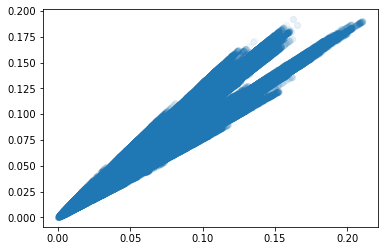

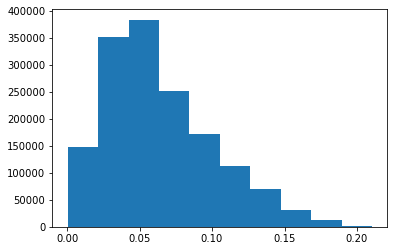

In [8]:
print(np.mean(slow_mean[:,:,0]))
print(dimension_means[0])

fig,ax = plt.subplots()
ax.scatter(good_array_dist.flatten(),normed_array_dist2.flatten(),alpha=.05)
fig.show()

fig,ax = plt.subplots()
ax.hist(good_array_dist.flatten())
fig.show()

0.07526404987925471 0.06380703625536677


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


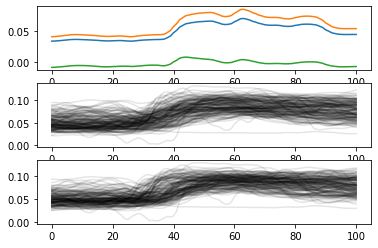

In [9]:
print(dimension_means[d],bird_dim_mean[d])
fig,(ax1,ax2,ax3) = plt.subplots(3)
d = 85
ax1.plot(bird_array_dist[10,:,d])
ax1.plot(slow_mean[10,:,d])
ax1.plot(slow_score[10,:,d] / 100)
for i in range(len(good_array_dist)):
    ax2.plot(good_array_dist[i,:,d],color='black',alpha=.1)
    ax3.plot(normed_array_dist2[i,:,d],color='black',alpha=.1)
fig.show()

In [9]:
## Partial Arrays
part_balance = min(len(part_array),len(csd_array))
X_part = np.vstack([csd_array[:part_balance],part_array[:part_balance]])
y_part = np.zeros(len(X_part))
y_part[:part_balance] = 1

Px_train = X_part[0::2]
Py_train = y_part[0::2]

Px_test = X_part[1::2]
Py_test = y_part[1::2]

In [10]:
## Prep song arrays
print(len(potent_list),len(weak_list))
potent_array = np.array(potent_list)
weak_array = np.array(weak_list)
potent_array_dist = np.array(potent_dist)
weak_array_dist = np.array(weak_dist)

max_balance = min(len(potent_array),len(weak_array))

potent_array = potent_array[:max_balance]
weak_array = weak_array[:max_balance]

Sx = np.vstack([potent_array,weak_array])
Sy = np.zeros(len(Sx))
Sy[:max_balance] = 1

Sx_train = Sx[0::2]
Sx_test = Sx[1::2]

Sy_train = Sy[0::2]
Sy_test = Sy[1::2]

50 74


In [11]:
## Prep high/low arrays
print(len(high_list),len(low_list))
low_array = np.array(low_list)
high_array = np.array(high_list)
low_array_dist = np.array(low_dist)
high_array_dist = np.array(high_dist)

max_balance = min(len(high_array),len(low_array))

high_array = high_array[:max_balance]
low_array = low_array[:max_balance]

Rx = np.vstack([high_array,low_array])
Ry = np.zeros(len(Rx))
Ry[:max_balance] = 1

Rx_train = Rx[0::2]
Rx_test = Rx[1::2]

Ry_train = Ry[0::2]
Ry_test = Ry[1::2]

83 42


In [12]:
## This characterizes CSD vs non-CSD
data = (csd_array_dist,non_array_dist)
iterations = 100

def bootstrap_RFC(data,iterations=100,bonus_data=[]):
    print('data set sizes:',len(data[0]),len(data[1]))
    p_train = .80
    p_test = 1-p_train

    target_array = np.zeros([data[0].shape[1],iterations])
    background_array = np.zeros_like(target_array)
    bonus_array = np.zeros_like(target_array)
    if len(bonus_data) > 0:
        bonus = True
    else:
        bonus = False
        
    ## For each time point
    for t in range(data[0].shape[1]):
        if t % 10 == 0:
            #print('time',t)
            pass
    ## Loop 1000 iterations
        t_scores,br_scores = [],[]
        bonus_scores = []
        for i in range(iterations):
            if i % 10 == 0:
                #print('iteration:',i)
                pass
    ## Sub sample (80/20) the dataset
            X_train,X_test = [],[]
            y_train,y_test = [],[]
            if True:
                max_len = np.min([len(data[0]),len(data[1])])
            else:
                max_len = -1
            test_len = [0,0]
            for k in range(2):

                data_perm = np.random.permutation(data[k][:,t])
                data_perm = data_perm[:max_len]
                train_i = round(len(data_perm) * p_train)
                #print(train_i)
                X_train.extend(data_perm[:train_i])
                X_test.extend(data_perm[train_i:])

                y_train.extend([1-k for n in range(train_i)])
                y_test.extend([1-k for n in range(len(data_perm) - train_i)])
                test_len[k] = len(data_perm) - train_i
            ## Train random forest, balancing for dataset size
            if False: ## Randomize train to see if it's actually real
                y_train = np.random.permutation(y_train)
            RF = RFC(n_estimators=200,max_depth=2)
            RF.fit(X_train,y_train)
            split = test_len[0]
            ## Calculate test performance for both CSD and non-CSD
            one_score = round(RF.score(X_test[:split],y_test[:split]),4)
            zero_score = round(RF.score(X_test[split:],y_test[split:]),4)
            t_scores.append(one_score)
            br_scores.append(zero_score)
            if bonus:
                
                bonus_perm = np.random.permutation(bonus_data[:,t])
                bonus_perm = bonus_perm[:round(len(bonus_perm) / 2)]
                bonus_score = round(RF.score(bonus_perm,[1]*len(bonus_perm)))
                bonus_scores.append(bonus_score)
        target_array[t] = np.array(t_scores)
        background_array[t] = np.array(br_scores)
        if bonus:
            bonus_array[t] = np.array(bonus_scores)
    return target_array,background_array,bonus_array

In [13]:
## This characterizes CSD vs non-CSD
#data = (csd_array_dist,song_pot_array)
#iterations = 100


## Data is a tuplet containing (n,t,d) array and the corresponding n labels.

## Run through each dimension and calculate it's predictive value and cost of removal
def bootstrap_dim_value(data,iterations=[200,20,20],classifier='RFC'):

    if isinstance(iterations,int):
        iterations = [iterations] * 3
    X,y = data
    perf_array = np.zeros(X.shape[2])
    cost_array = np.zeros_like(perf_array)
    print('generating base performance...')
    test_scores,random_scores = bootstrap_simple(data,iterations=iterations[0],classifier=classifier)
    base_perf = np.median(test_scores) / np.median(random_scores)
    print('base perf:',base_perf)
    for d in range(X.shape[2]):
        print('Working on dimension',d)
        X_d = X[:,:,d]
        data_d = (X_d,y)
        test_scores,random_scores = bootstrap_simple(data_d,iterations=iterations[1],classifier=classifier)
        perf = np.median(test_scores) / np.median(random_scores)
        perf_array[d] = perf
        print('  value:',perf)
        X_sans_d = np.array(X)
        X_sans_d[:,:,d] = 0
        data_sans = (X_sans_d,y)
        test_scores,random_scores = bootstrap_simple(data_sans,iterations=iterations[2],classifier=classifier)
        perf_sans = np.median(test_scores) / np.median(random_scores)
        print('  sans perf:',perf_sans)
        cost_array[d] = perf_sans / base_perf
        print('  cost:',cost_array[d])
        
    return perf_array,cost_array

## Run on entire postures
def bootstrap_simple(data,iterations=100,classifier='RF'):
    X,y = data
    #print('len:',np.shape(X),np.shape(y))
    test_scores = np.zeros(iterations)
    random_scores = np.zeros(iterations)
    
    ## Convert to ints, in case of continuous labels
    if not isinstance(np.min(y),int):
        y = np.array(np.round(y,2)) * 100
        y = np.round(y).astype(int)
    if classifier == 'RFC':
        CF = RFC(n_estimators=200,max_depth=2,class_weight='balanced')
    elif classifier == 'LR':
        CF = LinearRegression(class_weight='balanced')
    elif classifier == 'LogR':
        CF = LogisticRegression(class_weight='balanced')
    else:
        print('classifier:',classifier,'not understood, using Random Forest')
        CF = RFC(n_estimators=200,max_depth=2,class_weight='balanced') 
        import pdb
        pdb.set_trace()
        
    for i in range(iterations):
        X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20)

        X_train = X_train.reshape(len(X_train),-1)
        X_test = X_test.reshape(len(X_test),-1)

          
        CF.fit(X_train,y_train)

        test_scores[i] = round(CF.score(X_test,y_test),4)
        random_scores[i] = round(CF.score(X_test,np.random.permutation(y_test)),4)
        
    return test_scores,random_scores

## Run on timewise postures
def bootstrap_shuffle(data,iterations=100,bonus_data=[],classifier='RFC'):
    X,y = data
    ## 
    if not isinstance(np.min(y),int):
        y = np.array(np.round(y,2)) * 100
        y = np.round(y).astype(int)
    print('classes:',np.unique(y,return_counts=True))

    target_array = np.empty([n_bins,iterations])
    background_array = np.empty([n_bins,iterations])
    bonus_array = np.empty([n_bins,iterations])
    if len(bonus_data) > 0:
        bonus = True
    else:
        bonus = False
        
    ## Define Classifier
    if classifier == 'RFC':
        CL = RFC(n_estimators=200,max_depth=2,class_weight='balanced')
    elif classifier == 'LR':
        CL = LinearRegression(class_weight='balanced')
    elif classifier == 'LogR':
        CL = LogisticRegression(class_weight='balanced')
    else:
        print('classifier:',classifier,'not understood, using Random Forest')
        CL = RFC(n_estimators=200,max_depth=2,class_weight='balanced')
        import pdb
        pdb.set_trace()
    
    for t in range(data[0].shape[1]):
        if t % 10 == 0:
            #print('time',t)
            pass
    ## Loop 1000 iterations
        t_scores,br_scores = [],[]
        bonus_scores = []
        for i in range(iterations):
            if i % 10 == 0:
                #print('iteration:',i)
                pass
    ## Sub sample (80/20) the dataset

            X_train,X_test,y_train,y_test=train_test_split(X[:,t],y,test_size=0.20)

            y_shuffle_test = np.random.permutation(y_test)

            CL.fit(X_train,y_train)
            
            ## Calculate test performance for both test and shuffled test
            test_score = round(CL.score(X_test,y_test),4)
            shuffle_score = round(CL.score(X_test,y_shuffle_test),4)
            t_scores.append(test_score)
            br_scores.append(shuffle_score)
            if bonus:
                
                bonus_perm = np.random.permutation(bonus_data[:,t])
                bonus_perm = bonus_perm[:round(len(bonus_perm) / 2)]
                bonus_score = round(RF.score(bonus_perm,[1]*len(bonus_perm)))
                bonus_scores.append(bonus_score)
        target_array[t] = np.array(t_scores)
        background_array[t] = np.array(br_scores)
        if bonus:
            bonus_array[t] = np.array(bonus_scores)
    return target_array,background_array,bonus_array



In [14]:
## Plot the two curves:
from scipy.stats import ttest_ind

def plot_rf(target_array,background_array,classes=['CSD','non-CSD'],song_onset=0,ts=np.arange(-1,4.0,5/100),NEG=False):
    fig,ax = plt.subplots()
    iterations = target_array.shape[1]
    t_mean = np.mean(target_array,axis=1)
    t_sem = np.std(target_array,axis=1) / np.sqrt(iterations)

    br_mean = np.mean(background_array,axis=1)
    br_sem = np.std(background_array,axis=1) / np.sqrt(iterations)

    #print(br_mean,br_sem)

    #print(target_array.shape,len(ts))
    ts=np.arange(-1,4.0,5/100) - song_onset
    if target_array.shape[0] == len(ts):
        pass
    else:
        ts = np.arange(target_array.shape[0]) - song_onset
    ax.plot(ts,np.mean(target_array,axis=1),label=classes[0])
    ax.fill_between(ts,t_mean + t_sem,t_mean - t_sem,color='tab:blue',alpha=.3)

    if NEG:
        ax.plot(ts,1 - np.mean(background_array,axis=1),label=classes[1])
        ax.fill_between(ts,1 - br_mean + br_sem,1 - br_mean - br_sem,color='tab:orange',alpha=.3)
    else:
        ax.plot(ts,np.mean(background_array,axis=1),label=classes[1])
        ax.fill_between(ts,br_mean + br_sem,br_mean - br_sem,color='tab:orange',alpha=.3)

    star_height = np.max([target_array,background_array]) + .1
    for t in range(len(ts)):
        t_stat,p_value = ttest_ind(target_array[t],background_array[t])
        if t_stat > 0:
            if p_value < .01:
                ax.scatter(ts[t],star_height,marker='*',color='black')
            if p_value < .001:
                ax.scatter(ts[t],star_height+.03,marker='*',color='black')
            if p_value < .0001:
                ax.scatter(ts[t],star_height+.06,marker='*',color='black') 

    ax.axvline(song_onset,color='black',label='Song Onset')
    #ax.axhline(.50,color='black',linestyle=':')
    ax.set_xlabel('time (bins)')
    ax.set_ylabel('Performance')


    ax.legend()
    fig.show()
    return fig,ax

#target_array2,background_array2,_ = bootstrap_RFC(data,iterations=10)
#_ = plot_rf(target_array2,background_array2)

### First, Plot Classifier

Ttest_indResult(statistic=48.86426189361733, pvalue=1.2785818942296736e-70)


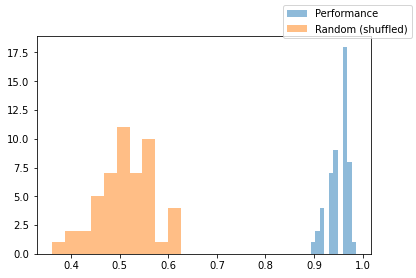

In [15]:
## Classifiers easily identify CSD vs non-CSD

posture_array = np.vstack([csd_array_dist,non_array_dist])
posture_labels = np.hstack([np.ones(len(csd_array_dist)),np.zeros(len(non_array_dist))])
bird_labels = np.hstack([bird_id_array,non_id_array])

data_pos = [posture_array,posture_labels]
test_scores_pos,br_scores_pos = bootstrap_simple(data_pos,iterations=50,classifier='LogR')

print(ttest_ind(test_scores_pos,br_scores_pos))

fig,ax = plt.subplots()

ax.hist(test_scores_pos,alpha=.5,label='Performance')
ax.hist(br_scores_pos,alpha=.5,label='Random (shuffled)')

fig.legend()
fig.show()

classes: (array([1, 2, 3, 4, 5, 6, 7]), array([77, 67, 29, 44, 16, 24,  1]))


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


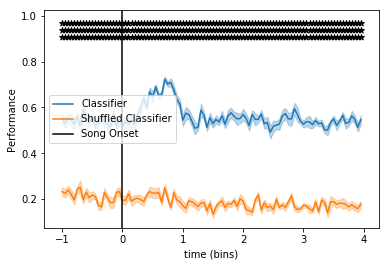

In [224]:
## Run time-wise for posture
target_array_pos,br_array_pos,_ = bootstrap_RFC_shuffle(data_pos,iterations=10)
_ = plot_rf(target_array_pos,br_array_pos,classes=['Classifier','Shuffled Classifier'])

In [300]:
## Check whether certain distances are most important for posture
data_pos = [posture_array,posture_labels]
perf_array2,cost_array2 = bootstrap_dim_value(data_pos,iterations=[200,10,10])

generating base performance...
base perf: 1.8518875192604007
Working on dimension 0
  value: 1.0545523305285052
  sans perf: 1.8846
  cost: 1.017664399375975
Working on dimension 1
  value: 1.1924
  sans perf: 1.8180958683936843
  cost: 0.9817528599792
Working on dimension 2
  value: 1.214113277623027
  sans perf: 1.8147327876745307
  cost: 0.9799368313682957
Working on dimension 3
  value: 1.148208782742681
  sans perf: 2.127683115733569
  cost: 1.1489267537065722
Working on dimension 4
  value: 1.1852850539291215
  sans perf: 1.8490973312401882
  cost: 0.9984933274882014
Working on dimension 5
  value: 1.2885
  sans perf: 1.8846
  cost: 1.017664399375975
Working on dimension 6
  value: 1.0178272980501393
  sans perf: 1.785515320334262
  cost: 0.9641597028783658
Working on dimension 7
  value: 1.320839874411303
  sans perf: 1.9216885897828082
  cost: 1.0376918521219283
Working on dimension 8
  value: 1.3399895995839834
  sans perf: 1.9798252911813643
  cost: 1.069085066231268
Working 

  value: 1.396193092621664
  sans perf: 1.9997920133111482
  cost: 1.0798668885191347
Working on dimension 79
  value: 1.4798252911813645
  sans perf: 1.8654000000000002
  cost: 1.0072965990639626
Working on dimension 80
  value: 1.2592449922958397
  sans perf: 1.8868720565149135
  cost: 1.0188912862636954
Working on dimension 81
  value: 1.2264521193092621
  sans perf: 1.9019168026101143
  cost: 1.0270152926834855
Working on dimension 82
  value: 1.5418201516793066
  sans perf: 1.9410685154975529
  cost: 1.0481568104486005
Working on dimension 83
  value: 1.4312805872756933
  sans perf: 1.7498607242339834
  cost: 0.9449065918068478
Working on dimension 84
  value: 1.6251354279523293
  sans perf: 1.9214926590538337
  cost: 1.037586051566043
Working on dimension 85
  value: 1.66069272912991
  sans perf: 1.689618074233459
  cost: 0.9123761873551866
Working on dimension 86
  value: 1.8797836938435941
  sans perf: 1.9216885897828082
  cost: 1.0376918521219283
Working on dimension 87
  valu

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


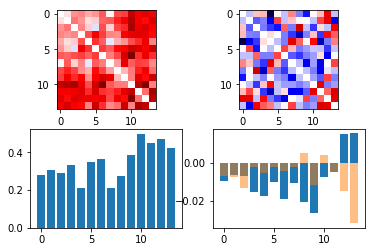

In [306]:
cost_square = -1*squareform(cost_array2-1)
np.fill_diagonal(cost_square,np.nan)
fig,axes = plt.subplots(2,2)
#ax.bar(range(len(perf_array)),perf_array)
#ax1.bar(range(len(cost_array)),cost_array)

axes[0,0].imshow(squareform(perf_array2-1),cmap='seismic',vmin=-1 * np.max(perf_array2-1),vmax=np.max(perf_array2-1))
axes[0,1].imshow(cost_square,cmap='seismic',vmin=-1 * np.max(cost_array2-1),vmax=np.max(cost_array2-1))

axes[1,0].bar(range(14),np.nanmean(squareform(perf_array2-1),0))
axes[1,1].bar(range(14),np.nanmean(cost_square,0))
axes[1,1].bar(range(14),-1*np.nanmean(squareform(cost_array-1),0),alpha=.5)
fig.show()

In [77]:
## Try to distinguish by song potency and response rate

print(bird_dict)
print(np.unique(bird_id_array,return_counts=True))
good_bids = [1,2,4,5,7,8]
bid = 8
data_sub = (csd_array_dist[bird_id_array == bid],song_pot_array[bird_id_array==bid])
#data_sub = (csd_array_dist[bird_id_array == bid],resp_rate_array[bird_id_array==bid])
#test_scores_sub,br_scores_sub = bootstrap_simple(data_sub,iterations=100,classifier='RFC')



{'CB-Yellow': 1, 'CB-Orange': 2, 'BK-0': 3, 'PINK2': 4, 'Y1': 5, 'WH2': 6, 'CB-LB2': 7, 'CB-Y2': 8, 'CB-R2': 9, 'CB-Red': 10, nan: 11, 'Pink3': 12, 'P1': 13}
(array([ 1,  2,  3,  4,  5,  7,  8, 10, 12, 13]), array([30, 40,  3, 23, 28, 11, 35,  1,  1,  1]))


Ttest_indResult(statistic=2.332784673934519, pvalue=0.020663705061538036)


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


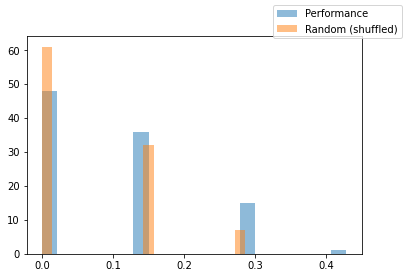

In [31]:
print(ttest_ind(test_scores_sub,br_scores_sub))
fig,ax = plt.subplots()

ax.hist(test_scores_sub,alpha=.5,bins=20,label='Performance')
ax.hist(br_scores_sub,alpha=.5,bins=20,label='Random (shuffled)')

fig.legend()
fig.show()

/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


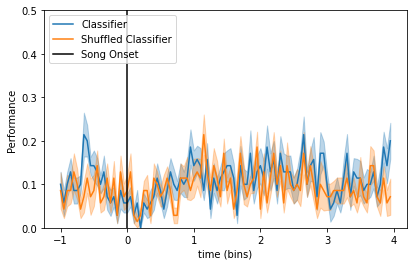

In [85]:
#target_array_sub,br_array_sub,_ = bootstrap_shuffle(data_sub,iterations=10)
fig,ax = plot_rf(target_array_sub,br_array_sub,classes=['Classifier','Shuffled Classifier'])
ax.set_ylim(0,.5)
ax.legend(loc='upper left')
fig.show()
fig.set_size_inches([6.5,4])
fig.savefig('./figures/4b_song_pot.png',dpi=300)

generating base performance...
base perf: 1.0
Working on dimension 0
  value: 0.5
  sans perf: 1.0
  cost: 1.0
Working on dimension 1
  value: 1.3333333333333333
  sans perf: 2.0
  cost: 2.0
Working on dimension 2
  value: 1.0
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 3
  value: 2.0
  sans perf: 1.5
  cost: 1.5
Working on dimension 4
  value: 1.0
  sans perf: 1.0
  cost: 1.0
Working on dimension 5
  value: 1.0
  sans perf: 1.25
  cost: 1.25
Working on dimension 6
  value: 0.25
  sans perf: 1.0
  cost: 1.0
Working on dimension 7
  value: 1.3333333333333333
  sans perf: 0.75
  cost: 0.75
Working on dimension 8
  value: 0.6666666666666666
  sans perf: 2.0
  cost: 2.0
Working on dimension 9
  value: 1.3333333333333333
  sans perf: 1.0
  cost: 1.0
Working on dimension 10
  value: 2.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 11
  value: 1.5
  sans perf: 1.6666666666666667
  cost: 1.6666666666666667
Working on dimension 12
  value: 2.0
  sans per

/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


  value: inf
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 22
  value: 1.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 23
  value: 1.0
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 24
  value: 2.0
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 25
  value: 1.5
  sans perf: 1.5
  cost: 1.5
Working on dimension 26
  value: 1.0
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 27
  value: 1.0
  sans perf: 1.0
  cost: 1.0
Working on dimension 28
  value: 2.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 29
  value: 1.0
  sans perf: 1.0
  cost: 1.0
Working on dimension 30
  value: 0.5
  sans perf: 1.0
  cost: 1.0
Working on dimension 31
  value: 1.5
  sans perf: 1.0
  cost: 1.0
Working on dimension 32
  value: 2.5


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


  sans perf: inf
  cost: inf
Working on dimension 33
  value: 0.6666666666666666
  sans perf: 2.0
  cost: 2.0
Working on dimension 34
  value: 1.0
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 35
  value: 2.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 36
  value: 1.5
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 37
  value: 2.0
  sans perf: 1.25
  cost: 1.25
Working on dimension 38
  value: 2.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 39


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


  value: inf
  sans perf: 2.0
  cost: 2.0
Working on dimension 40
  value: 0.0
  sans perf: 1.0
  cost: 1.0
Working on dimension 41
  value: 1.0
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 42
  value: 4.0
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 43
  value: 1.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 44
  value: 0.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 45
  value: 2.0
  sans perf: 1.0
  cost: 1.0
Working on dimension 46
  value: 1.0
  sans perf: 0.8
  cost: 0.8
Working on dimension 47
  value: 2.0
  sans perf: 1.25
  cost: 1.25
Working on dimension 48
  value: 1.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 49
  value: 1.0
  sans perf: 1.0
  cost: 1.0
Working on dimension 50
  value: 1.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 51
  value: 1.5
  sans perf: 1.0
  cost: 1.0
Working on dimension 52
  value: 1.0
  sans perf: 1.0
  cost: 1.0
Working on dimension 53
  value: 0.0
 

/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


  value: inf
  sans perf: 0.5
  cost: 0.5
Working on dimension 66
  value: 1.0
  sans perf: 2.5
  cost: 2.5
Working on dimension 67
  value: 1.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 68
  value: 1.5
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 69
  value: 1.0
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 70
  value: 1.0
  sans perf: 1.5
  cost: 1.5
Working on dimension 71
  value: 0.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 72


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


  value: inf
  sans perf: 0.6
  cost: 0.6
Working on dimension 73
  value: 2.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 74
  value: 1.0
  sans perf: 0.75
  cost: 0.75
Working on dimension 75
  value: 1.0
  sans perf: 1.0
  cost: 1.0
Working on dimension 76


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


  value: inf
  sans perf: 0.75
  cost: 0.75
Working on dimension 77
  value: 1.0
  sans perf: 1.0
  cost: 1.0
Working on dimension 78
  value: 0.0
  sans perf: 1.6666666666666667
  cost: 1.6666666666666667
Working on dimension 79
  value: 1.3333333333333333
  sans perf: 1.3333333333333333
  cost: 1.3333333333333333
Working on dimension 80
  value: 1.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 81
  value: 2.0
  sans perf: 1.0
  cost: 1.0
Working on dimension 82
  value: 1.0
  sans perf: 2.0
  cost: 2.0
Working on dimension 83
  value: 2.0
  sans perf: 1.5
  cost: 1.5
Working on dimension 84
  value: 1.5
  sans perf: 1.5
  cost: 1.5
Working on dimension 85
  value: 0.6666666666666666
  sans perf: 1.0
  cost: 1.0
Working on dimension 86
  value: 3.0
  sans perf: 1.0
  cost: 1.0
Working on dimension 87
  value: 1.0
  sans perf: 0.5
  cost: 0.5
Working on dimension 88
  value: 0.5
  sans perf: 0.5
  cost: 0.5
Working on dimension 89
  value: 4.0
  sans perf: 0.6666666666666666
  cos

/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/matplotlib/image.py:447: RuntimeWarning: invalid value encountered in double_scalars
  vmid = self.norm.vmin + dv / 2


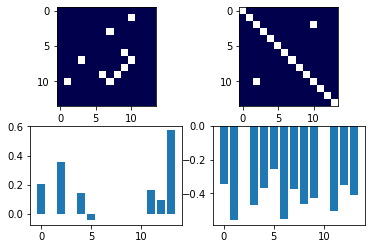

In [16]:
## This cell takes around 5 minutes
bid = 2
#data_sub = (csd_array_dist[bird_id_array == bid],song_pot_array[bird_id_array==bid])
data_sub = (csd_array_dist[bird_id_array == bid],resp_rate_array[bird_id_array==bid])

perf_sub,cost_sub = bootstrap_dim_value(data_sub,iterations=[200,10,10])

cost_square = -1*squareform(cost_sub-1)
perf_square = squareform(perf_sub-1)
np.fill_diagonal(cost_square,np.nan)
fig,axes = plt.subplots(2,2)
#ax.bar(range(len(perf_array)),perf_array)
#ax1.bar(range(len(cost_array)),cost_array)

axes[0,0].imshow(perf_square,cmap='seismic',vmin=-1 * np.nanmax(perf_square),vmax=np.nanmax(perf_square))
axes[0,1].imshow(cost_square,cmap='seismic',vmin=np.nanmin(cost_square),vmax=-1*np.nanmin(cost_square))

axes[1,0].bar(range(14),np.nanmean(perf_square,0))
axes[1,1].bar(range(14),np.nanmean(cost_square,0))
#axes[1,1].bar(range(14),-1*np.nanmean(squareform(cost_array-1),0),alpha=.5)
fig.show()

Ttest_indResult(statistic=3.788572441454733, pvalue=0.00020095389631567505)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


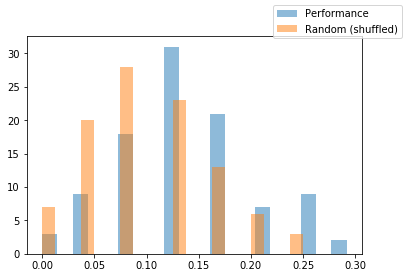

In [200]:
data_pot = (csd_array_dist,song_pot_array)
test_scores_p,br_scores_p = bootstrap_RFC_simple(data_pot,iterations=100)

print(ttest_ind(test_scores_p,br_scores_p))

fig,ax = plt.subplots()

ax.hist(test_scores_p,alpha=.5,bins=20,label='Performance')
ax.hist(br_scores_p,alpha=.5,bins=20,label='Random (shuffled)')

fig.legend()
fig.show()

classes: (array([15, 23, 24, 26, 33, 35, 36, 39, 45, 65]), array([ 7,  9, 10, 10, 11, 12, 14, 12, 11, 21]))


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


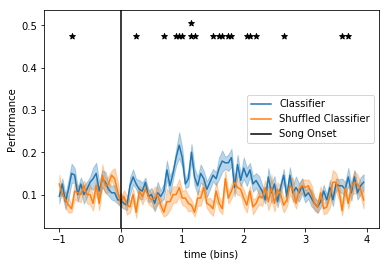

In [205]:
#data_pot = (csd_array_dist,song_pot_array)

target_array_pot,br_array_pot,_ = bootstrap_RFC_shuffle(data_pot,iterations=10)
_ = plot_rf(target_array_pot,br_array_pot,classes=['Classifier','Shuffled Classifier'])

Ttest_indResult(statistic=5.829050931332701, pvalue=2.2334967992021682e-08)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


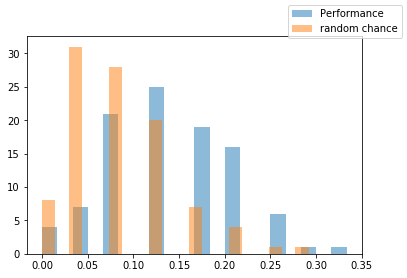

In [202]:
data_resp = (csd_array_dist,resp_rate_array)

test_scores_r,br_scores_r = bootstrap_RFC_simple(data_resp,iterations=100)

print(ttest_ind(test_scores_r,br_scores_r))

fig,ax = plt.subplots()

ax.hist(test_scores_r,alpha=.5,bins=20,label='Performance')
ax.hist(br_scores_r,alpha=.5,bins=20,label='random chance')

fig.legend()
fig.show()

classes: (array([ 0,  9, 10, 12, 22, 30, 33, 36, 40, 42, 43, 50, 56, 60, 62, 67, 70,
       75, 78, 80, 89, 90]), array([ 2,  2,  2,  1,  1,  8,  5,  6, 14,  3,  3, 11,  3,  1,  7,  9, 12,
        1,  6,  3,  8,  9]))


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


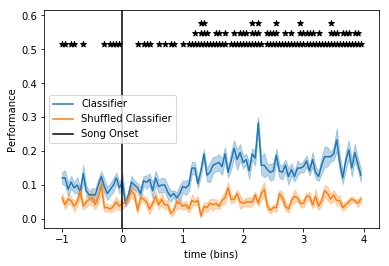

In [206]:
data_resp = (csd_array_dist,resp_rate_array)

target_array_resp,br_array_resp,_ = bootstrap_RFC_shuffle(data_resp,iterations=10)
_ = plot_rf(target_array_resp,br_array_resp,classes=['Classifier','Shuffled Classifier'])

In [209]:
np.save('csd_array_dist.npy',csd_array_dist)

# Are There Gestures? 

### Finally doing this I guess
1. First, look for velocity spikes in point space
2. Do PCA to see what that does
3. Might as well through a umap in as well for kicks
4. Once I've got a good space, look for points of density
5. Then I'll need to do trajectory clustering (but that's a different question really)

In [121]:
## Calculate transition probabilities 1 time (some randomness here because of ties)

(173, 101, 17, 3)
(173,)
0.050000000000000044


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


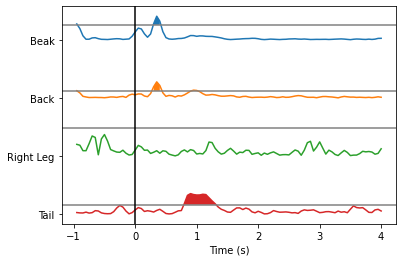

In [16]:
## First generate velocity array and plot example
print(data_array.shape)
print(bird_id_array.shape)
vel_array = np.diff(data_array,axis=1)
norm_array = np.linalg.norm(vel_array,axis=3)

fig,ax = plt.subplots()

for k,y in [[0,0.06],[4,.04],[8,.02],[10,0]]:
    plot_line = norm_array[22,:,k] + y
    thresh = np.nanmean(plot_line[:20]) + np.nanstd(plot_line[:20]) * 3 

    #ts = np.arange(-20,79)
    ts = np.linspace(-1,4,101)[1:] ## ts are shifted here to use vel=t(i)-(t(i-1))

    iterations = 50
    points = 15
    np.zeros([iterations,points,2])



    ax.plot(ts,plot_line)
    ts_sub = ts[plot_line > thresh]
    ax.fill_between(ts,plot_line,[thresh]*len(ts),where=plot_line >= thresh)
    ax.axhline(thresh,color='gray')

ax.set_yticks([0.00,.02,.04,.06])
ax.set_yticklabels(['Tail','Right Leg','Back','Beak'])
ax.axvline(0,color='black')
ax.set_xlabel('Time (s)')
fig.show()

print(ts[20])

-1 18.0635838150289 0.15512011182318486
0 18.03636363636364 0.1561436310191028
1 16.113043478260874 0.2430794303269462
2 11.19512195121951 0.5944755273387599
3 17.81739130434783 0.16457689984236193
4 21.866666666666667 0.057462424457931024
5 9.210526315789474 0.75686400581536
6 5.3 0.9679816297076268
*
7 31.3801652892562 0.0029655799210695976
[ 4.  8.  5.  5.  6.  6.  6.  8. 12. 11.  9. 11.  8. 22.]
*
8 36.44144144144144 0.0005065687275492882
[ 6.  4.  9.  7.  3.  3.  6. 10.  6.  7.  8. 10. 10. 22.]
9 8.214814814814815 0.8293292115707531
*
10 42.190184049079754 6.096534527683986e-05
[ 9.  8. 10.  5. 11. 13.  9. 12. 11. 14. 14.  9. 31.  7.]
*
11 29.34108527131783 0.005854049277979028
[ 9.  5.  6.  4.  5. 10.  9.  6.  9.  9. 20. 12.  8. 17.]
12 17.0 0.19930407456556032
*
13 46.484662576687114 1.1801591127624932e-05
[ 5. 12.  9.  6.  8. 15. 13. 11.  9. 13. 31. 13. 13.  5.]
[13. 10. 14. 11. 14. 12. 14. 12. 13. 13. 14. 14. 13. 13.]
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 1

/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: Mean of empty slice
/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


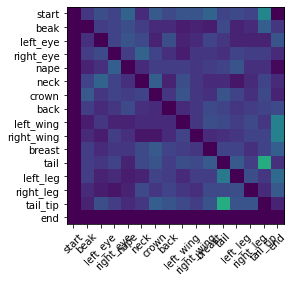

In [17]:
geasture_points = [[] for k in range(14)]
response_points = [[] for k in range(14)]
response_groups = [[] for k in range(14)]

## Build combined part dict

point_part_list = [[0,1,2,5],[3,4,6,9],[7],[8],[10,13],[11],[12]]

point_part_dict = {
    0:0, #beak
    1:0, #l. eye
    2:0, #r. eye
    3:1, #nape
    4:1, #neck
    5:0, #crown
    6:1, #breast
    7:2, #l. wing
    8:3, #r. wing
    9:1, #back
    10:4,#tail
    11:5,#l. leg
    12:6,#r. leg
    13:4 #tail tip
}

flat_labels,flat_list = [],[]
seq_starts = np.empty([len(data_array),14])
seq_orders = np.empty_like(seq_starts)

seq_counts = np.zeros_like(seq_starts)
seq_starts.fill(np.nan)

seq_orders.fill(np.nan)



for s in range(len(data_array)):
    #sequence_starts = np.zeros(14)
    for k in range(14):
        plot_line = norm_array[s,:,k]
        thresh = np.nanmean(plot_line[:20]) + np.nanstd(plot_line[:20]) * 3
        for t in np.arange(1,len(plot_line)-1):
            if plot_line[t-1] < thresh and plot_line[t] >= thresh:
                geasture_points[k].append(ts[t])
                if ts[t] > 0 and ts[t] <= 20:
                    response_points[k].append(ts[t])
                    flat_labels.append(k)
                    flat_list.append(ts[t])
                    seq_counts[s,k] += 1
                    ## Add the first place it crosses 
                    if np.isnan(seq_starts[s,k]):
                        seq_starts[s,k] = ts[t] + np.round((np.random.rand() - .5) / 40,4) # Add some jitter to break ties
        
    #print(np.argsort(seq_starts[s]))
    ## Filter out non-peaks, so they're just np.nan
    n_values = np.sum(~np.isnan(seq_starts[s]))
    seq_orders[s,:n_values] = np.argsort(seq_starts[s])[:n_values].astype(int)

#print(seq_orders)
#print(seq_starts)
## Make part arrays
part_starts = np.empty([len(data_array),7])
part_starts.fill(np.nan)
part_orders = np.empty_like(part_starts)
part_orders.fill(np.nan)

for i in range(7):
    part_starts[:,i] = np.nanmean(seq_starts[:,point_part_list[i]],axis=1)

transitions = np.zeros([16,16])

for s in range(len(data_array)):
    if np.isnan(seq_orders[s,0]):
        continue
    else:
        first_key = int(seq_orders[s,0]) + 1
    transitions[0,first_key] += 1
    for k in range(1,14):
        last_key = seq_orders[s,k-1] + 1
        new_key = seq_orders[s,k] + 1
        if np.isnan(new_key):
            #print(k,last_key,new_key)
            transitions[int(last_key),-1] += 1
            break
        transitions[int(last_key),int(new_key)] += 1

fig,ax = plt.subplots()
ax.imshow(transitions,vmax=50)
ax.set_yticks(np.arange(len(coco_keypoint_list)+2))
ax.set_yticklabels(np.hstack(['start',coco_keypoint_list,'end']))
ax.set_xticks(np.arange(len(coco_keypoint_list)+2))
ax.set_xticklabels(np.hstack(['start',coco_keypoint_list,'end']),rotation=45)
fig.show()

base_i = np.arange(1,len(transitions))
for r in range(len(transitions)-1):
    indices = base_i[base_i != r]
    if r == 0:
        indices = indices[:-1]
    chi,p_value = chisquare(transitions[r,indices])
    if p_value < .05:
        print('*')
        print(r-1,chi,p_value)
        print(transitions[r,indices])
    else:
        print(r-1,chi,p_value)
        
print(np.max(seq_counts,0))
for k in range(14):
    print(np.unique(seq_counts[:,k],return_counts=True))

In [18]:
np.unique(bird_id_array,return_counts=True)

(array([ 1,  2,  3,  4,  5,  7,  8, 10, 12, 13]),
 array([30, 40,  3, 23, 28, 11, 35,  1,  1,  1]))

In [478]:
## Bootstrap above transition to deal with ties
def bootstrap_transitions(data_array,iterations=50):
    K = 14 #data_array.shape[2] # could be more flexible...
    P = 7
    points = K + 1
    ts = np.linspace(-1,4,101)[:-1]
    chi_log = np.zeros([iterations,points,2])
    part_log = np.zeros([iterations,8,2])
    
    vel_array = np.diff(data_array,axis=1)
    norm_array = np.linalg.norm(vel_array,axis=3)

    for i in range(iterations):
        geasture_points = [[] for k in range(K)]
        response_points = [[] for k in range(K)]
        response_groups = [[] for k in range(K)]
        flat_labels,flat_list = [],[]
        neg_labels,neg_list = [],[]
        seq_starts = np.empty([len(data_array),K])
        seq_orders = np.empty_like(seq_starts)

        seq_starts.fill(np.nan)
        seq_orders.fill(np.nan)
        for s in range(len(data_array)):

            for k in range(14):
                plot_line = norm_array[s,:,k]
                thresh = np.nanmean(plot_line[:20]) + np.nanstd(plot_line[:20]) * 3
                for t in np.arange(1,len(plot_line)-1):
                    if plot_line[t-1] < thresh and plot_line[t] >= thresh:
                        geasture_points[k].append(ts[t])
                        if ts[t] >= -1 and ts[t] <= 4:
                            t_c = t+1 ### Correct to backward velocity (t - t-1) to offset smoothing and binning
                            response_points[k].append(ts[t_c])
                            flat_labels.append(k)
                            flat_list.append(ts[t_c])
                            ## Add the first place it crosses 
                            if np.isnan(seq_starts[s,k]):
                                seq_starts[s,k] = ts[t_c] + np.round((np.random.rand()) * .0001,5) # Add some jitter to break ties
                        if ts[t_c] < 0:
                            #import pdb
                            #pdb.set_trace()
                            neg_labels.append(k)
                            neg_list.append(ts[t_c])
            ## Filter out non-peaks, so they're just np.nan
            n_values = np.sum(~np.isnan(seq_starts[s]))
            seq_orders[s,:n_values] = np.argsort(seq_starts[s])[:n_values].astype(int)

        ## Initialize part arrays
        part_starts = np.empty([len(data_array),7])
        part_starts.fill(np.nan)
        part_orders = np.empty_like(part_starts)
        part_orders.fill(np.nan)

        ### Fill in part orders
        for p in range(P):
            part_starts[:,p] = np.nanmedian(seq_starts[:,point_part_list[p]],axis=1)
        for s in range(len(data_array)):
            n_values = np.sum(~np.isnan(part_starts[s]))
            part_orders[s,:n_values] = np.argsort(part_starts[s])[:n_values].astype(int)
            
        transitions = np.zeros([16,16])
        part_transitions = np.zeros([9,9])
        
        ## Step through sequences
        for s in range(len(data_array)):
            # if there's no points for this sequence, just move on
            if np.isnan(seq_orders[s,0]):
                continue
            else:
                first_key = int(seq_orders[s,0]) + 1
            transitions[0,first_key] += 1
            for k in range(1,K):
                last_key = seq_orders[s,k-1] + 1
                new_key = seq_orders[s,k] + 1
                if np.isnan(new_key):
                    #print(k,last_key,new_key)
                    transitions[int(last_key),-1] += 1
                    break
                transitions[int(last_key),int(new_key)] += 1
                
            ## Do the part transitions
            first_part = int(part_orders[s,0]) + 1
            part_transitions[0,first_part] += 1
            for p in range(1,P):
                last_key = part_orders[s,p-1] + 1
                new_key = part_orders[s,p] + 1
                ## If the new key is nan, you can skip to the end
                if np.isnan(new_key):
                    part_transitions[int(last_key),-1] += 1
                    break
                part_transitions[int(last_key),int(new_key)] += 1
        
        base_i = np.arange(1,len(transitions))
        for r in range(len(transitions)-1):
            indices = base_i[base_i != r]
            if r == 0:
                indices = indices[:-1]
            chi_log[i,r] = chisquare(transitions[r,indices])
        base_p = np.arange(1,len(part_transitions))
        for r in range(len(part_transitions) - 1):
            indices = base_p[base_p != r]
            if r == 0:
                indices = indices[:-1]
            part_log[i,r] = chisquare(part_transitions[r,indices])
    return chi_log, part_log, [transitions,part_transitions], [seq_starts,part_starts]

np.set_printoptions(suppress=True)
chi_log,part_log,[transitions,part_transitions],[seq_starts,part_starts] = bootstrap_transitions(data_array[:,:,:14])
print('All Keypoints')
print(np.round(np.nanmean(chi_log,0),4))
print('\nParts')
print(np.round(np.nanmean(part_log,0),4))

/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


All Keypoints
[[13.4671  0.4568]
 [23.483   0.1253]
 [20.9082  0.1584]
 [16.9532  0.2993]
 [25.2673  0.0702]
 [17.6736  0.2668]
 [13.5905  0.4709]
 [13.2762  0.4726]
 [27.8549  0.0329]
 [34.5636  0.0024]
 [16.2496  0.2991]
 [34.4638  0.0295]
 [25.5621  0.0417]
 [20.2752  0.164 ]
 [46.5252  0.0076]]

Parts
[[ 3.3773  0.7475]
 [40.9171  0.    ]
 [22.7342  0.0033]
 [ 8.8762  0.2213]
 [ 5.3309  0.5266]
 [12.5701  0.1137]
 [11.3821  0.1312]
 [ 9.7357  0.199 ]]


In [129]:
print(data_array.shape)

(173, 101, 17, 3)


[[0.    0.144 0.139 0.242 0.222 0.163 0.163 0.194]
 [0.134 0.    0.266 0.089 0.154 0.193 0.133 0.089]
 [0.062 0.222 0.    0.194 0.154 0.181 0.141 0.194]
 [0.188 0.111 0.127 0.    0.103 0.102 0.126 0.073]
 [0.17  0.078 0.108 0.097 0.    0.114 0.104 0.089]
 [0.161 0.242 0.133 0.21  0.137 0.    0.141 0.177]
 [0.179 0.118 0.108 0.048 0.103 0.163 0.    0.185]
 [0.107 0.085 0.12  0.121 0.128 0.084 0.193 0.   ]]
All Keypoints
[[12.9653  0.4505]
 [23.2872  0.0384]
 [20.6401  0.0804]
 [16.3427  0.2316]
 [24.      0.0311]
 [17.464   0.1802]
 [12.6741  0.4733]
 [12.536   0.4845]
 [27.2439  0.0117]
 [33.6903  0.0013]
 [16.      0.2491]
 [34.5111  0.001 ]
 [25.2665  0.0213]
 [20.0588  0.0938]
 [46.3298  0.    ]]

Parts
[[ 3.0116  0.8074]
 [39.9521  0.    ]
 [22.6497  0.0009]
 [ 8.8684  0.1811]
 [ 4.9236  0.5536]
 [11.6405  0.0705]
 [10.7406  0.0969]
 [ 8.8723  0.1809]]


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


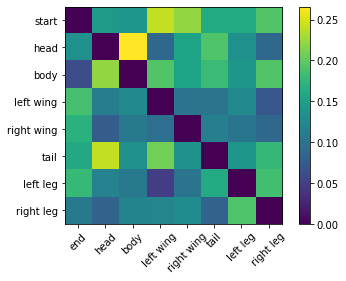

In [482]:
fig,ax = plt.subplots()
normed_transitions = part_transitions / (np.nansum(part_transitions,0))
normed_transitions = normed_transitions[:-1,[-1,1,2,3,4,5,6,7]]
im = ax.imshow(normed_transitions,vmax=np.nanmax(normed_transitions))
ax.set_yticks(np.arange(len(part_label_list)+1))
ax.set_yticklabels(np.hstack(['start',part_label_list]))
ax.set_xticks(np.arange(len(part_label_list)+1))
ax.set_xticklabels(np.hstack(['end',part_label_list]),rotation=45)

fig.colorbar(im,ax=ax)

fig.show()

print(np.round(normed_transitions,3))
print('All Keypoints')
print(np.round(np.nanmedian(chi_log,0),4))
print('\nParts')
print(np.round(np.nanmedian(part_log,0),4))

In [497]:
print(chisquare(normed_transitions[0,1:]))
for i in range(8):
    print(normed_transitions[i,np.arange(8) != i])
    print(chisquare(normed_transitions[i,np.arange(8) != i]))
#print(np.nanmedian(part_log,0))

Power_divergenceResult(statistic=0.051740413778632637, pvalue=0.9999971697327447)
[0.14379085 0.13924051 0.24193548 0.22222222 0.1626506  0.16296296
 0.19354839]
Power_divergenceResult(statistic=0.051740413778632637, pvalue=0.9999971697327447)
[0.13392857 0.26582278 0.08870968 0.15384615 0.19277108 0.13333333
 0.08870968]
Power_divergenceResult(statistic=0.15429294009958805, pvalue=0.9999277700384346)
[0.0625     0.22222222 0.19354839 0.15384615 0.18072289 0.14074074
 0.19354839]
Power_divergenceResult(statistic=0.09984364895355678, pvalue=0.9999800253183158)
[0.1875     0.11111111 0.12658228 0.1025641  0.10240964 0.12592593
 0.07258065]
Power_divergenceResult(statistic=0.06383916616413314, pvalue=0.9999947078539959)
[0.16964286 0.07843137 0.10759494 0.09677419 0.11445783 0.1037037
 0.08870968]
Power_divergenceResult(statistic=0.04822409788857773, pvalue=0.9999977054261362)
[0.16071429 0.24183007 0.13291139 0.20967742 0.13675214 0.14074074
 0.17741935]
Power_divergenceResult(statistic=

7 160
(173, 7)


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


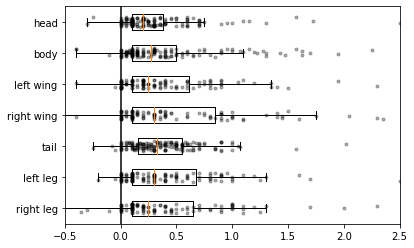

In [474]:
## Plot Mean time of first velocity
fig,ax = plt.subplots()
part_label_list = ['head','body','left wing','right wing','tail','left leg','right leg']

#ax.bar(np.arange(14),np.nanmean(seq_starts,0) /100)
mask = ~np.isnan(part_starts)
filtered_data = [d[m] for d, m in zip(part_starts.transpose(), mask.transpose())]
ax.boxplot(filtered_data,vert=False,positions=np.arange(0,part_starts.shape[1])[::-1],showfliers=False)
anova_point_list = [0 for n in range(7)]
tukey_labels = [0 for n in range(7)]
for p in range(7):
    n_points = np.sum(~np.isnan(part_starts[:,p]))
    jitter = (np.random.rand(n_points) - .5) * .3
    ax.scatter(part_starts[:,p][~np.isnan(part_starts[:,p])],[6-p]*n_points+jitter,
               alpha=.3,color='black',marker='.')
    anova_point_list[p] = part_starts[:,p][~np.isnan(part_starts[:,p])]
    tukey_labels[p] = [p] * len(anova_point_list[p])
ax.set_yticklabels(part_label_list)
ax.set_xlim(-.5,2.5)
ax.axvline(0,color='black')
#ax.set_xticks(np.linspace(0,4,5))
#ax.set_xticklabels(np.round(np.linspace(0,4/20,5),2))
fig.show()

print(len(filtered_data),len(filtered_data[0]))
print(part_starts.shape)

In [476]:

print(f_oneway(*anova_point_list))

flat_anova_list = [item for sublist in anova_point_list for item in sublist]
flat_tukey_labels = [item for sublist in tukey_labels for item in sublist]
print(pairwise_tukeyhsd(flat_anova_list,flat_tukey_labels))

F_onewayResult(statistic=3.080368958236597, pvalue=0.005422655471206958)
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.1366 0.4807 -0.0757 0.3489  False
     0      2   0.2212 0.0569 -0.0034 0.4458  False
     0      3   0.2626 0.0125  0.0343  0.491   True
     0      4   0.0952 0.8038 -0.1128 0.3032  False
     0      5   0.2443 0.0179  0.0249 0.4637   True
     0      6   0.1647 0.3148 -0.0599 0.3893  False
     1      2   0.0845    0.9 -0.1423 0.3114  False
     1      3    0.126 0.6501 -0.1045 0.3566  False
     1      4  -0.0414    0.9 -0.2518  0.169  False
     1      5   0.1077 0.7556  -0.114 0.3293  False
     1      6   0.0281    0.9 -0.1988 0.2549  False
     2      3   0.0415    0.9 -0.2005 0.2834  False
     2      4  -0.1259 0.6178 -0.3488 0.0969  False
     2      5   0.0231    0.9 -0.2104 0.2566  False
     2      6  -0.0565    0.9 -0.2949  0.18

# Define a posture space

### Okay nerds, time to really go into it. 

1. Perform PCA to get the most basic posture space
2. Play around with UMAP to see if there's a nicer posture space
3. Cluster postures by bird, song, etc to see if there's pools
4. Look for dense points that would suggest geastures

[3.98910965e-01 1.18814780e-01 8.36935034e-02 5.95588491e-02
 5.12726770e-02 3.26431562e-02 2.64580671e-02 2.39684192e-02
 1.93366105e-02 1.78702742e-02 1.52007672e-02 1.24966012e-02
 1.20172185e-02 1.12866742e-02 1.02114699e-02 8.86510934e-03
 8.16619189e-03 6.64556998e-03 6.02353970e-03 5.76032968e-03
 4.88544963e-03 4.54010832e-03 4.03563059e-03 3.94818275e-03
 3.78607076e-03 3.70762881e-03 3.35471127e-03 3.10153212e-03
 2.90284549e-03 2.86677658e-03 2.53564308e-03 2.08171881e-03
 1.96405492e-03 1.91302514e-03 1.83370609e-03 1.65091323e-03
 1.59372756e-03 1.52514104e-03 1.32245975e-03 1.23151971e-03
 1.13190430e-03 1.03602993e-03 9.59405453e-04 9.25666790e-04
 8.42409064e-04 7.64054620e-04 7.59687931e-04 6.85640781e-04
 6.71509211e-04 6.26038904e-04 5.64244256e-04 5.53658616e-04
 5.09849800e-04 4.61835658e-04 4.55170150e-04 4.11744505e-04
 3.70833381e-04 3.59022043e-04 2.97836086e-04 2.90625706e-04
 2.85318193e-04 2.47909335e-04 2.25281618e-04 2.20828061e-04
 2.10936596e-04 1.834840

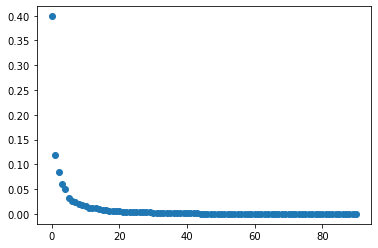

In [17]:
from sklearn.decomposition import PCA, FastICA

"""
pca_data = all_normed_dist2
pca_ids = all_good_id_array
"""
pca_data = normed_array_dist2
pca_ids = good_id_array

#all_poses = np.reshape(good_array_dist,[-1,91])
all_poses = np.reshape(pca_data,[-1,91])
pca = PCA()
u_poses = pca.fit_transform(all_poses)

print(pca.explained_variance_ratio_)

fig,ax = plt.subplots()
ax.scatter(range(pca.n_components_),pca.explained_variance_ratio_)
fig.show()

print(np.sum(pca.explained_variance_ratio_[:11]))

In [18]:
len(pca_ids)

167

-0.3562427668707189 0.3674378087165078


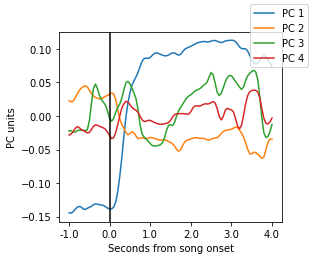

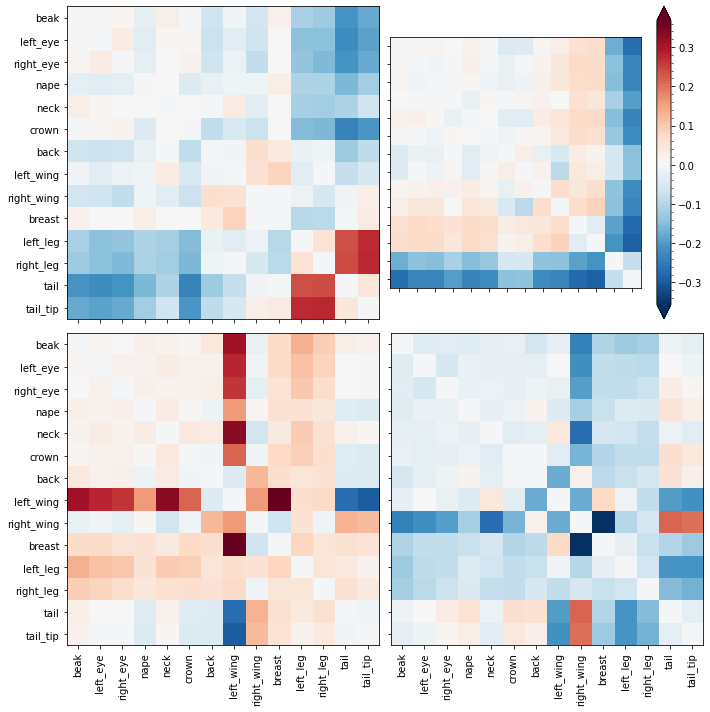

In [130]:

fig, ax = plt.subplots()
example_bird = 3

csd_array_pca = np.reshape(u_poses,pca_data.shape)

ax.plot(csd_array_pca[example_bird,:,0],label='PC 1')
ax.plot(csd_array_pca[example_bird,:,1],label='PC 2')
ax.plot(csd_array_pca[example_bird,:,2],label='PC 3')
ax.plot(csd_array_pca[example_bird,:,3],label='PC 4')
ax.axvline(20,color='black')

ax.set_xticks(np.arange(0,101,20))
ax.set_xticklabels(np.arange(-1,4.1,1))
ax.set_xlabel('Seconds from song onset')
ax.set_ylabel('PC units')
fig.legend()

fig.set_size_inches(4,3.5)
fig.show()

fig,axes = plt.subplots(2,2,sharex=True,sharey=True)

#ax.bar(np.arange(91),pca.components_[0])

# Rearrange the square so the heatmaps make more sense. 
squares = [0,1,2,3]
max_s,min_s = 0,0
for s in range(4):
    squares[s] = squareform(pca.components_[s])
    squares[s] = squares[s][nice_order]
    squares[s] = squares[s][:,nice_order]
    if np.max(squares[s]) > max_s:
        max_s = np.max(squares[s])
    if np.min(squares[s]) < min_s:
        min_s = np.min(squares[s])

axes[0,0].imshow(squares[0],vmax=max_s,vmin=min_s,cmap='RdBu_r')
top_right = axes[0,1].imshow(squares[1],vmax=max_s,vmin=min_s,cmap='RdBu_r')
axes[1,0].imshow(squares[2],vmax=max_s,vmin=min_s,cmap='RdBu_r')
axes[1,1].imshow(squares[3],vmax=max_s,vmin=min_s,cmap='RdBu_r')

cbar = fig.colorbar(top_right, ax=axes[0,1], extend='both')
cbar.minorticks_on()


axes[0,0].set_yticks(np.arange(len(nice_order)))
axes[0,0].set_yticklabels(np.array(coco_keypoint_list)[nice_order])

axes[1,1].set_xticks(np.arange(len(nice_order)))
axes[1,1].set_xticklabels(np.array(coco_keypoint_list)[nice_order],rotation=90)
axes[1,0].set_xticklabels(np.array(coco_keypoint_list)[nice_order],rotation=90)
print(min_s,max_s)
fig.set_size_inches(10,10)
fig.tight_layout()
fig.show()

In [20]:
print(np.array(coco_keypoint_list)[nice_order])

['beak' 'left_eye' 'right_eye' 'nape' 'neck' 'crown' 'back' 'left_wing'
 'right_wing' 'breast' 'left_leg' 'right_leg' 'tail' 'tail_tip']


In [203]:
print(pca_ids)

# One of the trajectories is mislabled, come back and figure out where it should go
if True:
    pca_ids[30] = 0
else:
    pca_ids[30] = 8
    
print(np.argwhere(pca_ids == 8))

[1 2 4 5 4 1 5 8 5 7 4 2 4 8 2 8 1 5 7 8 1 1 5 5 2 1 5 5 7 2 8 4 8 2 7 2 5
 2 5 2 8 8 5 8 2 8 5 2 5 1 2 2 8 7 4 4 1 2 2 2 5 5 1 5 2 1 2 5 5 8 1 2 4 8
 8 4 7 2 1 5 1 8 4 4 5 8 2 4 1 8 7 5 5 4 1 1 4 2 1 2 2 8 2 2 8 8 1 8 8 8 2
 4 2 4 8 2 8 1 2 2 7 4 8 8 2 1 8 5 2 2 2 1 4 2 2 4 7 8 1 8 2 5 1 1 7 5 8 4
 1 1 4 8 5 4 2 1 4 8 7 1 8 2 5 8 1 5 1]
[[  7]
 [ 13]
 [ 15]
 [ 19]
 [ 32]
 [ 40]
 [ 41]
 [ 43]
 [ 45]
 [ 52]
 [ 69]
 [ 73]
 [ 74]
 [ 81]
 [ 85]
 [ 89]
 [101]
 [104]
 [105]
 [107]
 [108]
 [109]
 [114]
 [116]
 [122]
 [123]
 [126]
 [137]
 [139]
 [146]
 [151]
 [157]
 [160]
 [163]]


In [87]:
print(np.unique(good_id_array,return_counts=True))

(array([1, 2, 4, 5, 7, 8]), array([30, 40, 23, 28, 11, 35]))


[False  True False False False False False False False False False  True
 False False  True False False False False False False False False False
  True False False False False  True False False False  True False  True
 False  True False  True False False False False  True False False  True
 False False  True  True False False False False False  True  True  True
 False False False False  True False  True False False False False  True
 False False False False False  True False False False False False False
 False False  True False False False False False False False False False
 False  True False  True  True False  True  True False False False False
 False False  True False  True False False  True False False  True  True
 False False False False  True False False False  True  True  True False
 False  True  True False False False False False  True False False False
 False False False False False False False False False False  True False
 False False False False False  True False False Fa

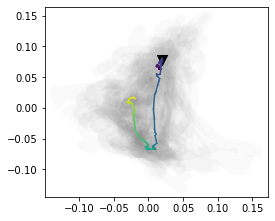

In [227]:
#pc_posture = pca.transform(csd_array_dist[3])

plot_bird = 2
csd_array_pca = np.reshape(u_poses,pca_data.shape)

bird_indices = pca_ids > 0
bird_indices = pca_ids == plot_bird
ex_id = np.argmax(bird_indices)

bv_indices = pca_ids < 5
bv_indices[pca_ids == 3] = 0

bv2_indices = (pca_ids) >= 5 & (pca_ids <= 8)
bv2_indices[pca_ids == 6] = 0

## plot one bird within the whole space
print(bird_indices)
if False:
    fig,ax = plt.subplots()
    for i in range(csd_array_pca.shape[0]):
        ax.plot(csd_array_pca[i,:,1],csd_array_pca[i,:,0],alpha=.06,color='black')
    ax.plot(csd_array_pca[ex_id,:,1],csd_array_pca[ex_id,:,0],color='red')
    mean_trajectory = np.nanmedian(csd_array_pca[bv_indices],axis=0)

    ax.plot(mean_trajectory[:,1],mean_trajectory[:,0],color='green')
    fig.show()

if True:
## Plot a bird within its own space, running PCA just on it's own
    sub_indices = good_id_array == plot_bird
    pca2 = PCA()
    flat_bird = np.reshape(normed_array_dist2[sub_indices],[-1,91])
    bird_transform = pca2.fit_transform(flat_bird)
    bird_reshaped = np.reshape(bird_transform,np.shape(normed_array_dist2[sub_indices]))


    fig,ax = plt.subplots()
    ex_id2 = 6
    color_map = plt.get_cmap('viridis')
    print(bird_reshaped.shape)
    for i in range(len(bird_reshaped)):
        ax.plot(bird_reshaped[i,:,1],bird_reshaped[i,:,0],linewidth=10,alpha=.02,color='black')
        #ax.text(bird_reshaped[i,0,1],bird_reshaped[i,0,0],str(i))
    #ax.plot(bird_reshaped[ex_id2,:,1],bird_reshaped[ex_id2,:,0],color='red')
   
    csd_point_cloud = np.reshape(bird_reshaped[:,:,:2].transpose(2,0,1),[2,-1])
    #ax.scatter(csd_point_cloud[1],csd_point_cloud[0],color='gray',alpha=.02,marker='.')
    density = gaussian_kde(csd_point_cloud)


    #ax.set_color_cycle([cm(1.*i/(NPOINTS-1)) for i in range(NPOINTS-1)])
    #x,y = bird_reshaped[ex_id2,:,1],bird_reshaped[ex_id2,:,0]
    x,y = np.nanmedian(bird_reshaped[:,:,1],axis=0),np.nanmedian(bird_reshaped[:,:,0],axis=0)
    NPOINTS = len(x)
    for i in range(NPOINTS-1):
        ax.plot(x[i:i+2],y[i:i+2],color=color_map(i/NPOINTS))
    ax.scatter(x[20],y[20],s=100,color='black',marker='v')
    #ax.scatter(x[40],y[40],s=100,color='red',marker='v')
    #ax.scatter(x[80],y[80],s=100,color='blue',marker='v')

    fig.set_size_inches(4,3.5)
    fig.show()

In [223]:

## bootsrap across trajectories, because neither the mean nor the median is necessarily real...
iterations = 1000
ts = np.arange(0,100)
all_paths = np.empty([iterations,100])

D = 11
csd_point_cloud = np.reshape(csd_array_pca[bird_indices,:,:D].transpose(2,0,1),[D,-1])
density = gaussian_kde(csd_point_cloud)

for i in range(iterations):
    
    #D = np.random.randint(2,92)
    p = np.random.choice(np.argwhere(bird_indices)[:,0])
    print(i, end='.')
    #D = 2


    sample_trajectory = csd_array_pca[p,:,:D]
    dense_path = np.array([float(np.log(density(sample_trajectory[t]))) for t in ts])
    
    #sample_trajectory = mean_trajectory[:,:D]
    #dense_path = np.array([float(np.log(density(mean_trajectory[t,:D]))) for t in ts])

    ## Clean up -inf values, because sometimes density == 0. But how can density = 0? b/c mean
    dense_path[np.isinf(dense_path)] = np.nanmin(dense_path[~np.isinf(dense_path)])

    safe_max = np.nanmax(dense_path)
    #print(safe_max,end='. ')
    if safe_max == 0:
        safe_max += .01
    dense_path = np.divide(np.array(dense_path),safe_max)

    all_paths[i] = dense_path

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.100.101.102.103.104.105.106.107.108.109.110.111.112.113.114.115.116.117.118.119.120.121.122.123.124.125.126.127.128.129.130.131.132.133.134.135.136.137.138.139.140.141.142.143.144.145.146.147.148.149.150.151.152.153.154.155.156.157.158.159.160.161.162.163.164.165.166.167.168.169.170.171.172.173.174.175.176.177.178.179.180.181.182.183.184.185.186.187.188.189.190.191.192.193.194.195.196.197.198.199.200.201.202.203.204.205.206.207.208.209.210.211.212.213.214.215.216.217.218.219.220.221.222.223.224.225.226.227.228.229.230.231.232.233.234.235.236.237.238.239.240.241.242.243.244.245.246.247.248.249.250.251.252.253.254.255.256.257.258.259.260.261.262.263.264.265.266.267.268.269.270.271.272.273.274.275.276.27

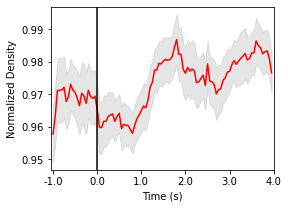

In [225]:
fig,ax = plt.subplots()
mean_path = np.nanmedian(all_paths,0)
std_path = np.nanstd(all_paths,0) / 2
#print(mean_path,std_path)


ax.fill_between(ts,mean_path + std_path,mean_path - std_path,alpha=.2,color='gray')
"""
for i in range(iterations):
    ax.plot(ts,all_paths[i],alpha=.005,color='black')
"""
ax.plot(ts,mean_path,color='red')
ax.axvline(20,color='black')

#ax.set_ylim([0.9,1.05])
ax.set_xlim(-1.1,4.1)
ax.set_xticks(np.arange(0,101,20))
ax.set_xticklabels(np.arange(-1,4.1,1))

ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized Density')
fig.set_size_inches(4,3)
fig.show()

[False  True False False False False False False False False False  True
 False False  True False False False False False False False False False
  True False False False False  True False False False  True False  True
 False  True False  True False False False False  True False False  True
 False False  True  True False False False False False  True  True  True
 False False False False  True False  True False False False False  True
 False False False False False  True False False False False False False
 False False  True False False False False False False False False False
 False  True False  True  True False  True  True False False False False
 False False  True False  True False False  True False False  True  True
 False False False False  True False False False  True  True  True False
 False  True  True False False False False False  True False False False
 False False False False False False False False False False  True False
 False False False False False  True False False Fa

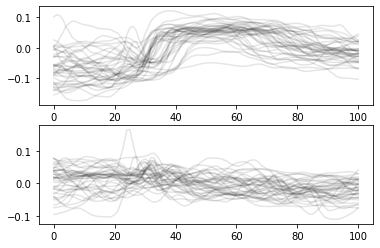

In [89]:
## What are those density peaks anyway? 
fig,(ax,ax1) = plt.subplots(2)

print(bird_indices)
for i in range(len(bird_indices)):
    if not bird_indices[i]:
        continue
    ax.plot(np.arange(0,csd_array_pca.shape[1]),csd_array_pca[i,:,0],alpha=.1,color='black')
    ax1.plot(np.arange(0,csd_array_pca.shape[1]),csd_array_pca[i,:,1],alpha=.1,color='black')
fig.show()

(173, 101, 91)
(11, 19190)
[4.2509069e+11]


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


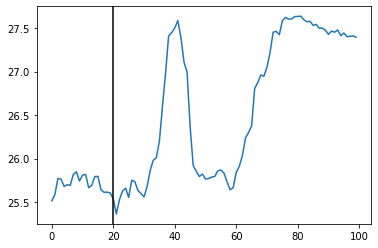

In [207]:
## Calculate density along the trajectories using one D

# First, generate n-dimensional density array
D = 11

print(csd_array_dist.shape)
csd_point_cloud = np.reshape(csd_array_pca[bird_indices,:,:D],[D,-1])
print(csd_point_cloud.shape)
density = gaussian_kde(csd_point_cloud)

print(density(csd_point_cloud[:,0]))
fig,ax = plt.subplots()

ts = np.arange(100)
#ax.plot(ts,[np.log(density(csd_array_pca[8,t])) for t in ts])
ax.plot(ts,[np.log(density(mean_trajectory[t,:D])) for t in ts])

ax.axvline(20,color='black')
fig.show()

In [208]:
print(np.unique(bird_id_array,return_counts=True))

(array([ 1,  2,  3,  4,  5,  7,  8, 10, 12, 13]), array([30, 40,  3, 23, 28, 11, 35,  1,  1,  1]))


In [485]:
## Cluster Trajectories using...something or other (UMAP? + dtw? probably not)

if False:
    bird_indices = pca_ids == 2
else:
    bird_indices = np.ones(len(pca_ids)) == 1
if False:
    song_indices = bird_indices & (song_pot_array == np.max(song_pot_array[bird_indices]))
    bird_indices = song_indices
    print(np.sum(bird_indices))

D=11
n_traj = len(csd_array_pca[bird_indices])
UM = umap.UMAP()
u = UM.fit_transform(np.reshape(csd_array_pca[bird_indices,:,:D],[n_traj,-1]))

In [491]:
## Define example clusters: 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 5)

points = u.reshape(-1,2)
kmeans.fit(points)
centroids = kmeans.cluster_centers_
pred_clusters = kmeans.predict(points)

print(points.shape)
print(pca_ids.shape)
print(bird_indices.shape)
#print(bird_id_array,pred_clusters)
## Print cluster score for original values
## output is -1 to 1, values near zero indicate overlapping clusters
## The exact values of the labels don't matter at all
#print(silhouette_score(points,pca_ids))
#print(silhouette_score(points,all_good_label_array))
print(silhouette_score(points,good_pot_array[bird_indices]))
print(silhouette_score(points,good_resp_array[bird_indices]))
print(silhouette_score(points,pred_clusters))

(167, 2)
(167,)
(167,)
-0.20815778
-0.5398302
0.5045411


No handles with labels found to put in legend.


(167, 2)
[1 2 4 5 7 8]


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


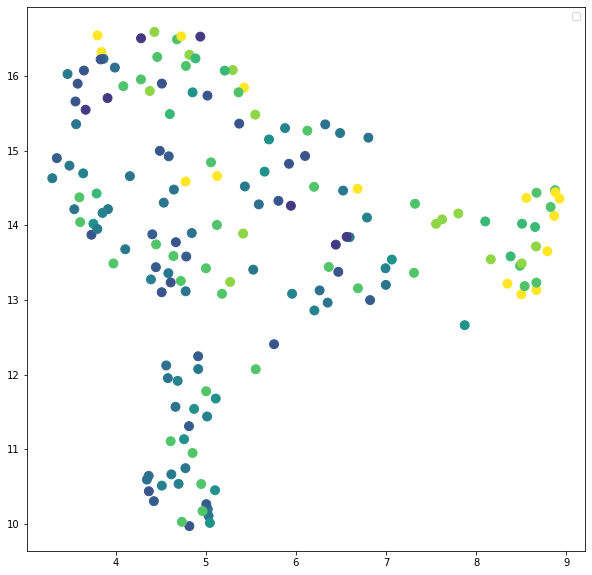

In [488]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

bird_id_color_vals = pca_ids[bird_indices] / np.max(pca_ids[bird_indices])

bird_id_colors = color_map(bird_id_color_vals) 

song_pot_colors = color_map(good_pot_array[bird_indices] / np.max(good_pot_array[bird_indices]))
#song_pot_colors = color_map(all_good_pot_array[bird_indices] / np.max(all_good_pot_array[bird_indices]))
#posture_label_colors = color_map(all_good_label_array / np.max(all_good_label_array))
#song_resp_colors = color_map()

pred_label_colors = color_map(pred_clusters / np.max(pred_clusters))

print(np.shape(u))
fig,ax = plt.subplots()

### Put in circles
print(np.unique(pca_ids))
## Get points by labels
if False:
    point_lists = [u[good_pot_array[bird_indices] == i,:2] for i in np.unique(good_pot_array[bird_indices])]
    #point_lists = [u[pca_ids == i,:2] for i in np.unique(pca_ids)]
    ## Find convex hull of points (for given labels)
    for i in range(len(point_lists)):
        if len(point_lists[i]) < 3:
            continue
        
        hull = ConvexHull(point_lists[i])

        ell = EllipseModel()
        ell.estimate(point_lists[i][hull.vertices])
        print(hull.vertices)
        try:
            xc, yc, a, b, theta = ell.params
        except:
            continue
        ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, 
                            edgecolor=color_map(i / len(point_lists)), 
                            facecolor=color_map(i / len(point_lists)),alpha=.2,label='Song'+str(i))
        ax.add_patch(ell_patch)

## Fit ellipse to the convex hull of points

## Plot ellipse

#cores = bird_id_colors
#cores = posture_label_colors
cores = song_pot_colors

ax.scatter(u[:,0],u[:,1],color=cores,s=80)
#ax.scatter(u[:,0],u[:,1],color=posture_label_colors,s=15)
#ax.scatter(centroids[:,0],centroids[:,1],color='red')
#ax.set_xlim([5,11])
#ax.set_ylim([1,6])
ax.legend()
fig.set_size_inches(10,10)
fig.show()

In [380]:
## Measuring Label clusterability
print(np.unique(bird_id_array))
values = np.unique(pca_ids)
remapped_id = np.array(pca_ids)
for i in range(len(values)):
    remapped_id[remapped_id == values[i]] = i
print(remapped_id,np.unique(remapped_id))
print(silhouette_score(points,remapped_id))


[ 1  2  3  4  5  7  8 10 12 13]
[0 1 2 3 2 0 3 5 3 4 2 1 2 5 1 5 0 3 4 5 0 0 3 3 1 0 3 3 4 1 5 2 5 1 4 1 3
 1 3 1 5 5 3 5 1 5 3 1 3 0 1 1 5 4 2 2 0 1 1 1 3 3 0 3 1 0 1 3 3 5 0 1 2 5
 5 2 4 1 0 3 0 5 2 2 3 5 1 2 0 5 4 3 3 2 0 0 2 1 0 1 1 5 1 1 5 5 0 5 5 5 1
 2 1 2 5 1 5 0 1 1 4 2 5 5 1 0 5 3 1 1 1 0 2 1 1 2 4 5 0 5 1 3 0 0 4 3 5 2
 0 0 2 5 3 2 1 0 2 5 4 0 5 1 3 5 0 3 0] [0 1 2 3 4 5]
0.1164895


In [457]:
## Measuring Maximum Naive Clusterability by optimizing k in k-means: 


## Adapted/Stolen from https://gist.github.com/KhyatiMahendru/
def max_sil(x,kmax=10):
    sil = []

    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(x)
        labels = kmeans.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    return np.argmax(sil) + 2,np.max(sil)

print(max_sil(points))

(2, 0.43274346)


In [216]:
## Get fibonacci up to 10
## I definitely spent longer getting the loop right than if I had just typed them in.
i = 1
j = 2

fibs = []
for _ in range(10):
    fibs.append(j)
    k = i+j
    i=j
    j=k
fibs = np.array(fibs)
print(fibs)

[  2   3   5   8  13  21  34  55  89 144]


In [395]:
## Bootstrap umap across multiple values to observe parameter space

def bootstrap_umap(X,labels=[],iterations=10,labels2=[]):
    dist_list = np.linspace(.1,1,10)
    neighborhoods = (fibs * ((len(X)-1)/fibs[-1])).astype(int)

    print('data:',X.shape)
    print('distance list:',dist_list)
    print('n_neighbors:',neighborhoods)
    naive_array = np.zeros([10,10])
    label_array = np.zeros([10,10])
    label_array2 = np.zeros([10,10])
    for d in range(len(dist_list)):
        print('progress: ',d,'of 10')
        for n in range(len(neighborhoods)):
            naive_sil = np.zeros(iterations)
            label_sil = np.zeros(iterations)
            label_sil2 = np.zeros(iterations)
            for i in range(iterations):
                UM = umap.UMAP(n_neighbors=neighborhoods[n],min_dist=dist_list[d])
                u = UM.fit_transform(X)
                _,naive_sil[i] = max_sil(u.reshape(-1,2))
                if len(labels) == len(X):
                    label_sil[i] = silhouette_score(u,labels=labels)
                if len(labels2) == len(X):
                    label_sil2[i] = silhouette_score(u,labels=labels2)
            naive_array[d,n] = np.median(naive_sil)
            label_array[d,n] = np.median(label_sil)
            label_array2[d,n] = np.median(label_sil2)
    print('Done!')
    return naive_array,label_array,label_array2

def bootstrap_sil(X,labels=[],iterations=10,params=[]):
    label_sil = np.zeros(iterations)
    
    for i in range(iterations):
        if len(params) == 0:
            UM=umap.UMAP()
        else:
            UM = umap.UMAP(n_neighbors=params[0],min_dist=params[1])
        u =  UM.fit_transform(X)      
        if len(labels) == 0:
            _,label_sil[i] = max_sil(u.reshape(-1,2))
        else:
            label_sil[i] = silhouette_score(u,labels=labels)
    return label_sil

n_traj = len(csd_array_pca[bird_indices])
D=11
X = np.reshape(csd_array_pca[bird_indices,:,:D],[n_traj,-1])
#naive_array,label_array,label_array2 = bootstrap_umap(X,labels=good_pot_array[bird_indices],iterations=2,labels2=good_id_array[bird_indices])
#_,label_array_non,_ = bootstrap_umap(X,labels=all_good_label_array,iterations=2)

[[-0.03505017  0.00070301  0.11023643  0.10142768  0.11300922  0.13975175
   0.14076128  0.12583     0.10836684  0.12190041]
 [-0.04131116  0.02341192  0.07306816  0.10572953  0.13290581  0.11519245
   0.13016574  0.12231804  0.10473166  0.10574758]
 [-0.09496996  0.02909913  0.08018177  0.11851486  0.11748878  0.12455177
   0.12049121  0.12711685  0.10670118  0.11044129]
 [-0.04746532  0.01129215  0.08448273  0.10222823  0.11902506  0.12577844
   0.11501008  0.11945646  0.11436138  0.10992685]
 [-0.07059647  0.02601174  0.07676888  0.09700073  0.11929048  0.12079051
   0.1243972   0.11160655  0.10940253  0.10422188]
 [-0.09363068  0.02746981  0.08013639  0.09622204  0.11706687  0.11218535
   0.12053841  0.10727168  0.09876568  0.09102674]
 [-0.05777911  0.06243964  0.08680901  0.08792309  0.11571367  0.11097552
   0.12135679  0.10436026  0.10193846  0.10533074]
 [-0.08866113  0.0612269   0.07771736  0.08444117  0.11935703  0.11873047
   0.10830914  0.09813016  0.0928999   0.09202635]


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


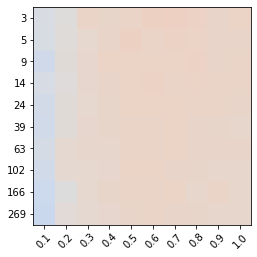

In [370]:
fig,ax = plt.subplots()
ax.imshow(label_array2,vmin=-1,vmax=1,cmap='coolwarm')

neighborhoods = (fibs * ((len(X)-1)/fibs[-1])).astype(int)
ax.set_xticks(np.arange(0,10))
ax.set_yticks(np.arange(0,10))
ax.set_xticklabels(np.round(np.linspace(.1,1,10),2),rotation=45)
ax.set_yticklabels(neighborhoods)
print(label_array2)
fig.show()

n_traj = len(csd_array_pca[bird_indices])
D=11
X = np.reshape(csd_array_pca[bird_indices,:,:D],[n_traj,-1])
print(n_traj)

print(np.unravel_index(label_array2.argmax(), label_array2.shape))

In [405]:
#sil_scores_pot = bootstrap_sil(X,good_pot_array[bird_indices]) #,params=[2,.2])
#sil_scores_id = bootstrap_sil(X,good_id_array[bird_indices])
#sil_scores_naive = bootstrap_sil(X,params=[2,.2])
#sil_scores_non = bootstrap_sil(X,all_good_label_array,params=[3,0.5])
print(sil_scores_pot)

[-0.200461   -0.21468991 -0.21217275 -0.21184699 -0.2155991  -0.22959374
 -0.20275021 -0.20943004 -0.20863116 -0.2236722 ]


[[ 0.6471765   0.62983817  0.58014244  0.58416855  0.62247062  0.63723552
   0.60089248  0.58206266  0.59895527  0.57111037]
 [-0.200461   -0.21468991 -0.21217275 -0.21184699 -0.2155991  -0.22959374
  -0.20275021 -0.20943004 -0.20863116 -0.2236722 ]
 [ 0.13635223  0.12642945  0.14272794  0.12036366  0.13360502  0.12196168
   0.13295732  0.12484743  0.13041973  0.11160732]
 [-0.09558883  0.08330195  0.16287802  0.0651511  -0.06461244  0.14985687
   0.0576237   0.11450647  0.03995775  0.17457032]
 [ 0.30030271  0.23973767  0.35576111  0.30595416  0.29319203  0.38585743
   0.35987413  0.32392776  0.28831917  0.33588919]]


/home/ammon/anaconda3/envs/r_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


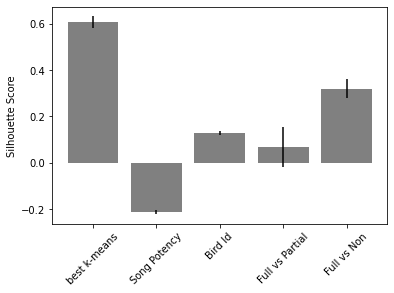

In [404]:
fig,ax = plt.subplots()

bar_array = np.vstack([sil_scores_naive,sil_scores_pot,sil_scores_id,sil_scores_partial,sil_scores_non])
print(bar_array)

ax.bar(range(len(bar_array)),np.mean(bar_array,1),yerr = np.std(bar_array,1),color='gray')
ax.set_xticks(range(5))
ax.set_xticklabels(['best k-means','Song Potency','Bird Id','Full vs Partial','Full vs Non'],rotation=45)
ax.set_ylabel('Silhouette Score')
fig.show()

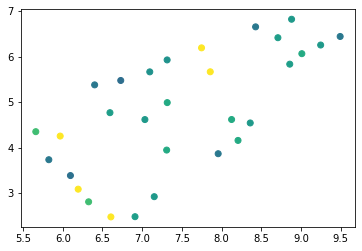

In [671]:
## One Umap, for fun
n_neighbors = 5 #range is 1 to max, biased towards lower values 
min_dist = .1 # (range is 0 to 1)
n_traj = len(csd_array_pca[sub_indices])
X = np.reshape(csd_array_pca[sub_indices,:,:D],[n_traj,-1])
D=11


    
UM = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
u = UM.fit_transform(X)


bird_id_color_vals = good_id_array[sub_indices] / np.max(good_id_array[sub_indices])
bird_id_colors = cm.viridis(bird_id_color_vals)
song_pot_colors = cm.viridis(good_pot_array[sub_indices] / np.max(good_pot_array[sub_indices]))

fig,ax = plt.subplots()

ax.scatter(u[:,0],u[:,1],color=song_pot_colors)

fig.show()

In [667]:
print(bird_id_array)

print(bird_dict)

[ 1  2  4  5  4  1  5  8  5  7  4  2  4  8  2  8  1  5  7  8  1  1  5  5
  2  1  5  5  7  2  8  4  8  2  7  2  5  2  5  2  8  8  5  8 10  2  8  5
  2  5  1  2  2  8  7  4  4  1  2  2  2  5  5  1  5  2  1  2  5  5  8  1
  2  4  8  8  4  7  2  1  5  1  8  4  4  5  8  2  4  1  8  7  5  5  4  1
  1  4  2  1  2  2  8  2  2  8  8  1  8  8  8  2  4 12  2  3  4  8  2  8
  1  2  2  7  4  8  8  2  1  8  5 13  2  2  3  2  1  4  2  2  4  7  8  1
  8  2  5  1  1  7  5  8  4  1  1  4  8  5  4  2  1  4  8  7  3  1  8  2
  5  8  1  5  1]
{'CB-Yellow': 1, 'CB-Orange': 2, 'BK-0': 3, 'PINK2': 4, 'Y1': 5, 'WH2': 6, 'CB-LB2': 7, 'CB-Y2': 8, 'CB-R2': 9, 'CB-Red': 10, nan: 11, 'Pink3': 12, 'P1': 13}


In [337]:
print(f_oneway(*response_points))
for k in response_points:
    print(np.mean(k))

F_onewayResult(statistic=0.9133413410355579, pvalue=0.5388080329202414)
19.14
18.225
18.30952380952381
18.19148936170213
18.04
17.692307692307693
18.930232558139537
17.966666666666665
18.324324324324323
18.57777777777778
19.689655172413794
18.076923076923077
16.615384615384617
18.261904761904763


In [75]:
def chunk_blocks(block_array):
    block_array2 = []
    new_I = block_array.shape[0] * 5
    for i in range(4):
        k = 5*i
        block_array2.append(np.reshape(block_array[:,k:k+5],[new_I,91]))

    block_array2 = np.array(block_array2)
    return block_array2.reshape([new_I,4,91])

print(chunk_blocks(potent_blocks).shape)

(160, 4, 91)


In [107]:


X = csd_array_dist
y = np.array(np.round(song_pot_array,2)) * 100
y = np.round(y).astype(int)

perm_i = np.random.permutation(np.arange(len(X)))

X_perm = X[perm_i]
y_perm = y[perm_i]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=0)
"""
X_train = X_perm[:160]
X_test = X_perm[160:]
y_train = y_perm[:160]
y_test = y_perm[160:]
"""
print(np.unique(y_train))
print(X_train.shape,y_train.shape,len(X_train))
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)
print(X_train.shape)

RF = RFC(n_estimators=200,max_depth=2,class_weight='balanced')
RF.fit(X_train,y_train)

#LR = LogisticRegression(random_state=0,solver='lbfgs',multi_class='ovr')
#LR.fit(X_train,y_train)

#print(LR.score(X_test,y_test))
print(RF.score(X_test,y_test))
print(RF.score(X_test,np.random.permutation(y_test)))

[15 23 24 26 33 35 36 39 45 65]
(93, 100, 91) (93,) 93
(93, 9100)
0.20833333333333334
0.16666666666666666


[15 23 24 26 33 35 36 39 45 65]


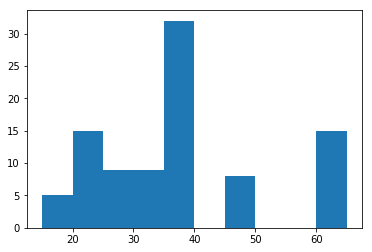

In [101]:
fig,ax = plt.subplots()
ax.hist(y_train)
print(np.unique(y_train))

data set sizes: 160 180


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


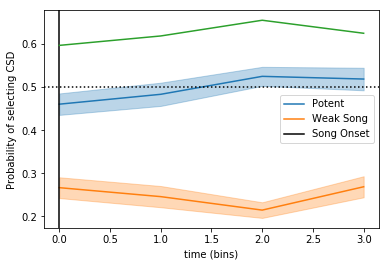

In [86]:
data = (chunk_blocks(potent_blocks),chunk_blocks(weak_blocks))

target_array,background_array,bonus_array = bootstrap_RFC(data,iterations=15)
_ = plot_rf(target_array,background_array,classes=['Potent','Weak Song'])

true_accuracy = (target_array + background_array) / 2

plt.plot(np.mean(true_accuracy,1))
plt.show()

data set sizes: 200 260


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


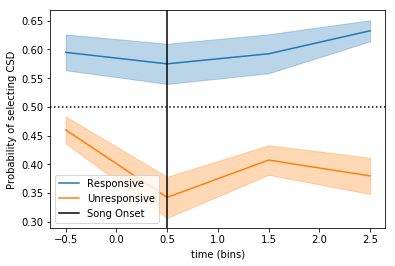

In [19]:
data = (chunk_blocks(high_blocks),chunk_blocks(low_blocks))
target_array,background_array,bonus_array = bootstrap_RFC(data,iterations=10)
_ = plot_rf(target_array,background_array,classes=['Responsive','Unresponsive'],song_onset=.5)

true_accuracy = (target_array + background_array) / 2

#plt.plot(np.arange(-5,3.1,.5),np.mean(true_accuracy,1))
plt.show()

(20, 10) (20, 10)
(20, 20)


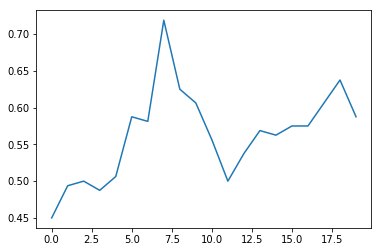

In [83]:
print(target_array.shape,background_array.shape)
print(np.hstack([target_array,background_array]).shape)
true_accuracy = (target_array + background_array) / 2

plt.plot(np.mean(true_accuracy,1))
plt.show()

data set sizes: 117 141


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


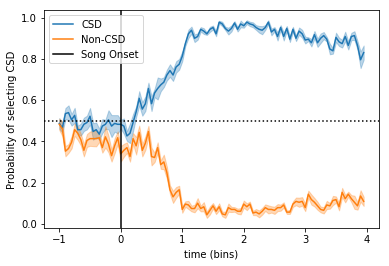

In [21]:
data = (csd_array_dist,non_array_dist)

target_array,background_array,_ = bootstrap_RFC(data,iterations=10)
_ = plot_rf(target_array,background_array,classes=['CSD','Non-CSD'])

data set sizes: 117 141


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


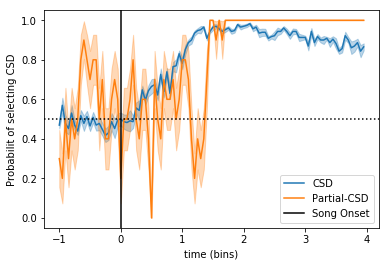

In [220]:
data = (csd_array_dist,non_array_dist)

target_array,background_array,bonus_array = bootstrap_RFC(data,iterations=10,bonus_data=part_array_dist)
_ = plot_rf(target_array,bonus_array,classes=['CSD','Partial-CSD'])

(18, 100, 91)
(100, 10)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


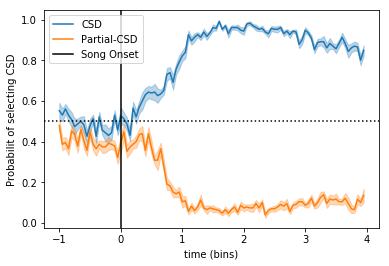

In [218]:
print(part_array_dist.shape)
print(bonus_array.shape)
_ = plot_rf(target_array,background_array,classes=['CSD','Partial-CSD'])

(117, 100, 91) (18, 100, 91)
data set sizes: 117 18
time 0
time 10
time 20
time 30
time 40
time 50
time 60
time 70
time 80
time 90


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


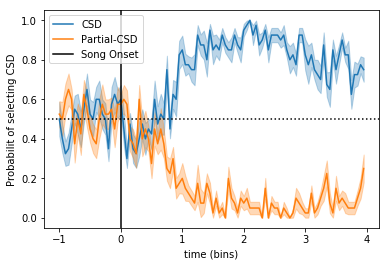

In [188]:
data = (csd_array_dist,part_array_dist)

print(csd_array_dist.shape,part_array_dist.shape)
target_array,background_array = bootstrap_RFC(data,iterations=10)
_ = plot_rf(target_array,background_array,classes=['CSD','Partial-CSD'])

data set sizes: 32 36


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


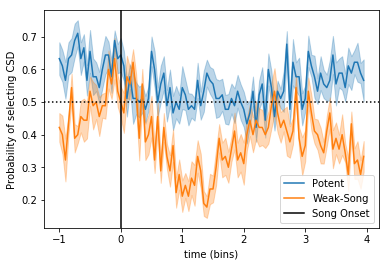

In [117]:
data = (potent_array_dist,weak_array_dist)

target_array_pot,background_array_weak,_ = bootstrap_RFC(data,iterations=15)
_ = plot_rf(target_array_pot,background_array_weak,classes=['Potent','Weak-Song'])

true_accuracy = (target_array + background_array) / 2

plt.plot(np.mean(true_accuracy,1))
plt.show()

data set sizes: 40 52


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


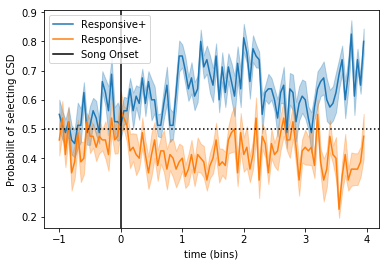

In [226]:
data = (high_array_dist,low_array_dist)

target_array_high,background_array_low,_ = bootstrap_RFC(data,iterations=10)
_ = plot_rf(target_array_high,background_array_low,classes=['Responsive+','Responsive-'])

In [230]:
print(np.mean(target_array_high[20:]),np.mean(background_array_low[20:]))
print(np.mean(target_array_pot[20:]),np.mean(background_array_weak[20:]))

0.64 0.58546875
0.5412509999999999 0.6083341250000001


In [77]:
import sklearn as sk
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_recall_curve as prc
from sklearn.metrics import roc_curve, auc, roc_auc_score

LR = LogisticRegression(random_state=0,solver='lbfgs',multi_class='ovr').fit(X_train,y_train)

round(LR.score(X_test,y_test),4)

0.9231

[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


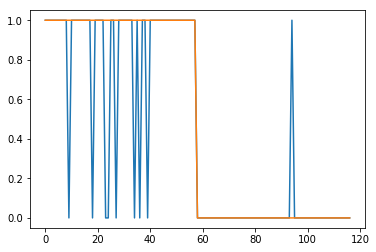

In [73]:
predictions = LR.predict(X_test)
print(predictions)
fig,ax = plt.subplots()
ax.plot(range(len(X_test)),predictions)
ax.plot(range(len(X_test)),y_test)

fig.show()


0.9231
(array([-1.,  0.,  1.]), array([  8, 108,   1]))


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


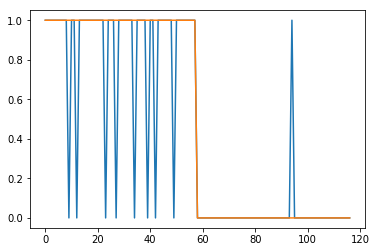

In [74]:
from sklearn import svm

SVM = svm.LinearSVC()
SVM.fit(X_train,y_train)
print(round(SVM.score(X_test,y_test),4))

predictions = SVM.predict(X_test)
#print(predictions)
fig,ax = plt.subplots()
ax.plot(range(len(X_test)),predictions)
ax.plot(range(len(X_test)),y_test)

print(np.unique(predictions - y_test,return_counts=True))
fig.show()

In [75]:
from sklearn.ensemble import RandomForestClassifier as RFC

RF = RFC(n_estimators=200,max_depth=2, random_state=0)
RF.fit(X_train,y_train)
round(RF.score(X_test,y_test),4)

0.9145

117
0.9720923436586791


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


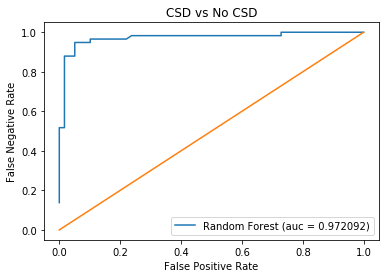

In [78]:
X_probs = RF.predict_proba(X_test)[:,1]
print(len(X_probs))
naive_probs = np.ones_like(X_probs)

fpr,tpr,_ = roc_curve(y_test,X_probs)
fpr_n,tpr_n,_ = roc_curve(y_test,naive_probs)

x_auc = auc(fpr,tpr)
print(x_auc)
x_label = 'Random Forest (auc = %f)' % x_auc
fig,ax = plt.subplots()
ax.plot(fpr,tpr,label=x_label)
ax.plot(fpr_n,tpr_n)

ax.set_title('CSD vs No CSD')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate') 
ax.legend()
fig.show()

In [79]:
## User a neural net
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(solver='lbfgs', alpha=1e-7, hidden_layer_sizes=(1, 1), random_state=1)
NN.fit(X_train, y_train)
#NN.predict(X)
round(NN.score(X_test,y_test), 4)

0.4957

In [80]:
## Neural net with Partial postures
X = np.vstack([csd_array[:20],part_array])
y = np.zeros(len(X))
print(X.shape)
y[:20] = 1

X_train,y_train = X[0::2],y[0::2]
X_test,y_test = X[1::2],y[1::2]

NN2 = MLPClassifier(solver = 'lbfgs',alpha=1e-5,hidden_layer_sizes=[1,1],random_state=1)
NN2.fit(X,y)
print(round(NN2.score(X,y),4))


(38, 100)
0.5263


In [81]:
## Three types with partial postures
SVM = svm.LinearSVC()
SVM.fit(Px_train,Py_train)
print('svm:',round(SVM.score(Px_test,Py_test),4))

RF = RFC(n_estimators=200,max_depth=2, random_state=0)
RF.fit(Px_train,Py_train)
print('RF:',round(RF.score(Px_test,Py_test),4))

LR = LogisticRegression(random_state=0,solver='lbfgs',multi_class='ovr')
LR.fit(Px_train,Py_train)
print('LR:',round(LR.score(Px_test,Py_test),4))

svm: 0.8889
RF: 0.9444
LR: 0.8333


18
1.0


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


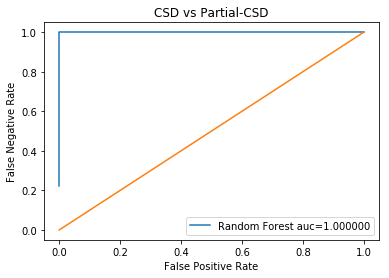

In [82]:
Px_probs = RF.predict_proba(Px_test)[:,1]
print(len(Px_probs))
naive_probs = np.ones_like(Px_probs)

fpr,tpr,_ = roc_curve(Py_test,Px_probs)
fpr_n,tpr_n,_ = roc_curve(Py_test,naive_probs)

print(auc(fpr,tpr))

p_label = 'Random Forest auc=%f' % auc(fpr,tpr)
fig,ax = plt.subplots()
ax.plot(fpr,tpr,label=p_label)
ax.plot(fpr_n,tpr_n)

ax.set_title('CSD vs Partial-CSD')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate') 

ax.legend()
fig.show()

In [83]:
SVM = svm.LinearSVC()
print(Sx_train.shape,Sy_train.shape)
SVM.fit(Sx_train,Sy_train)
print('svm:',round(SVM.score(Sx_test,Sy_test),4))

RF = RFC(n_estimators=200,max_depth=2, random_state=0)
RF.fit(Sx_train,Sy_train)
print('RF:',round(RF.score(Sx_test,Sy_test),4))

LR = LogisticRegression(random_state=0,solver='lbfgs',multi_class='ovr').fit(Sx_train,Sy_train)
print('LR:',round(LR.score(Sx_test,Sy_test),4))

(32, 100) (32,)
svm: 0.5
RF: 0.5625
LR: 0.4375


32
0.6640625


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


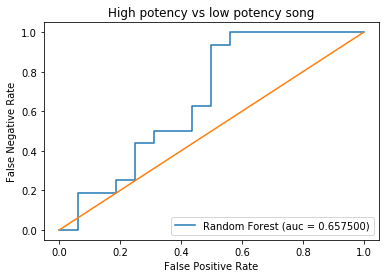

In [88]:
Sx_probs = RF.predict_proba(Sx_test)[:,1]
print(len(Sx_probs))
naive_probs = np.ones_like(Sx_probs)

s_label = 'Random Forest (auc = %f)' %auc(fpr,tpr)
fpr,tpr,_ = roc_curve(Sy_test,Sx_probs)
fpr_n,tpr_n,_ = roc_curve(Sy_test,naive_probs)

print(auc(fpr,tpr))

fig,ax = plt.subplots()
ax.plot(fpr,tpr,label=s_label)
ax.plot(fpr_n,tpr_n)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')

ax.set_title('High potency vs low potency song')
ax.legend()
fig.show()

In [203]:
### Run on responsive vs low_responsive
print(len(Rx_train))

SVM = svm.LinearSVC()
print(Rx_train.shape,Ry_train.shape)
SVM.fit(Rx_train,Ry_train)
print('svm:',round(SVM.score(Rx_test,Ry_test),4))

RF = RFC(n_estimators=200,max_depth=2, random_state=0)
RF.fit(Rx_train,Ry_train)
print('RF:',round(RF.score(Rx_test,Ry_test),4))

LR = LogisticRegression(random_state=0,solver='lbfgs',multi_class='ovr').fit(Rx_train,Ry_train)
print('LR:',round(LR.score(Rx_test,Ry_test),4))

40
(40, 100) (40,)
svm: 0.625
RF: 0.55
LR: 0.525


0.55
auc: 0.66


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


"\nfig,ax = plt.subplots()\nax.plot(recall,precision)\nax.plot(rec_naive,prec_naive,linestyle=':')\nax.set_xlabel('Recall')\nax.set_ylabel('Precision')\nfig.show()\n"

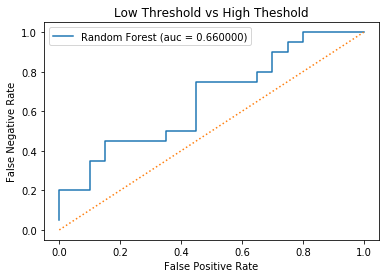

In [204]:
## Plot ROC curve for responsivity
M = RF ## Assign model for this
print(round(M.score(Rx_test,Ry_test),4))
probs = M.predict_proba(Rx_test)[:,1]
naive_probs = np.ones_like(probs)
y_true = Ry_test


precision, recall, thresholds = prc(y_true,probs)
prec_naive,rec_naive,_ = prc(y_true,naive_probs)

fpr, tpr, _ = roc_curve(y_true,probs)
fpr_n,tpr_n,_ = roc_curve(y_true,naive_probs)

print('auc:',auc(fpr,tpr))
#print(auc(fpr_n,tpr_n))

fig,ax = plt.subplots()

p_label = 'Random Forest (auc = %f)' %auc(fpr,tpr)

ax.plot(fpr,tpr,label=p_label)
ax.plot(fpr_n,tpr_n,linestyle=':')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('Low Threshold vs High Theshold')
ax.legend()
fig.show()

"""
fig,ax = plt.subplots()
ax.plot(recall,precision)
ax.plot(rec_naive,prec_naive,linestyle=':')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
fig.show()
"""

In [87]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 

masks = np.load('test_masks.npy')
course_masks = np.load('course_masks.npy')

fig,(ax1,ax2) = plt.subplots(2)

ax1.imshow(masks[0])
ax2.imshow(course_masks[0])

x_dim = 1024
y_dim = 1024
scale = 1./8
big_step = 1024 * scale
step = 103
points = []
for n in np.arange(0,x_dim,step):
    for m in np.arange(0,y_dim,step):
        x_course = int(n/big_step)
        y_course = int(m/big_step)
        if course_masks[0][y_course,x_course] > .1:
            if (x_course,y_course) not in points:
                points.append((x_course,y_course))

points = np.array(points)
print(points)
ax2.scatter(points[:,0],points[:,1],color='red')


fig.show()

FileNotFoundError: [Errno 2] No such file or directory: 'test_masks.npy'

In [26]:
test_dict = {}
test_dict[(1,2,3)] = 1
test_dict[(2,3,4)] = 1

False

In [32]:
(124.9 // 5) * 5

120.0

In [27]:
sample_rate = 48000
onset_df = pd.read_csv('/data/birds/postures/birdview-2019/2019-onsets-birdview.txt',header=None,delim_whitespace=True)
volume_row = onset_df[onset_df[0] == '2019-06-08-11-46-13_ND.wav.bag']
offset = volume_row[5]
print(offset.item() / 48000)

1.4345625


292


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


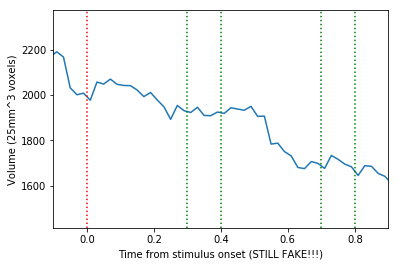

In [29]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 


#volumes = np.load('/data/birds/postures/birdview-2019/2019-06-11-08-46-12_WG_short/2019-06-11-08-46-12_WG_short_volume.npy')
volumes = np.load('/data/birds/postures/birdview-2019/2019-06-04-10-16-10_BDY_short/2019-06-04-10-16-10_BDY_short_volume.npy')
#volumes = np.load('/data/birds/postures/birdview-2019/2019-06-08-13-16-12_BDY/2019-06-08-13-16-12_BDY_volume.npy')

#volumes = np.load('/data/birds/postures/birdview-2019/2019-06-08-11-46-13_ND2019-06-08-11-46-13_ND_volume.npy')
#vol_onset = onset_df[]
print(len(volumes))
fig,ax = plt.subplots()

ax.plot(np.arange(0,len(volumes) * .02,.02) - 1.53,volumes)
ax.axvline(0,linestyle=':',color='red')

ax.axvline(0.3,linestyle=':',color='green')
ax.axvline(0.4,linestyle=':',color='green')

ax.axvline(0.7,linestyle=':',color='green')
ax.axvline(0.8,linestyle=':',color='green')
#ax.plot(volumes0,alpha=.8)
ax.set_ylabel('Volume (25mm^3 voxels)')
ax.set_xlabel('Time from stimulus onset (STILL FAKE!!!)')

ax.set_xlim([-0.1,.9])
fig.show()
#fig.savefig('/home/ammon/Desktop/PaperFigs/wingstroke_trace_close.svg')

(1024, 1024)
1.0


/home/ammon/anaconda3/envs/vak-env/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


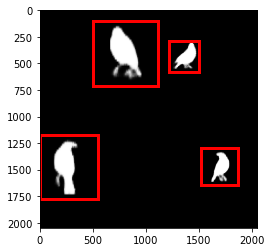

In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches

masks = np.load('./2019-06-24-11-46-15_BDY_clipped/masks/masks_5.npy')
boxes = np.load('./2019-06-24-11-46-15_BDY_clipped/masks/box_5.npy')

masks = np.load('/data/birds/postures/birdview-2019/2019-06-08-13-16-12_BDY/masks/masks_371.npy')
boxes = np.load('/data/birds/postures/birdview-2019/2019-06-08-13-16-12_BDY/masks/box_371.npy')
fig,ax = plt.subplots()

#ax.imshow(np.sum(masks,0))
print(masks[0].shape)
all_mask = np.zeros([2048,2048])
all_mask[:1024,:1024] = masks[0]
all_mask[:1024,1024:] = masks[1]
all_mask[1024:,:1024] = masks[2]
all_mask[1024:,1024:] = masks[3]

all_mask[1020:1028,:] = 1
all_mask[:,1020:1028] = 1
ax.imshow(all_mask,cmap='Greys_r')
#ax.imshow(masks[0],cmap='Greys_r')

print(np.max(all_mask))
x_offset = [0,1024,0,1024]
y_offset = [0,0,1024,1024]

for b in range(len(boxes)):
    (x0,y0,x1,y1) = boxes[b]
    w = x1 - x0
    h = y1 - y0
    rect = patches.Rectangle((x0+x_offset[b],y0+y_offset[b]),w,h,linewidth=3,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)


    
fig.savefig('/home/ammon/Desktop/PaperFigs/masks_all.png',dpi=300)
fig.show()


In [291]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
import numpy as np

%matplotlib inline
#clouds = np.load('/data/birds/postures/birdview-2019/2019-06-08-13-16-12_BDY/2019-06-08-13-16-12_BDY_cloud.npy')
clouds = np.load('/home/ammon/Documents/Scripts/deep-high-resolution-net.pytorch/demo/test_cloud.npy')

print(np.shape(clouds))

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
f = 5

cloud_array = np.array(clouds[f])

color_map = cm.get_cmap('viridis')
z_max,z_min = np.max(cloud_array[:,2]),np.min(cloud_array[:,2])
z_range = z_max - z_min
"""
clip_points = np.load('./2019-06-24-11-46-15_BDY_clipped/pred_keypoints_3d.npy')
clip_points = clip_points * 1000
"""
for p in range(len(cloud_array)):
    height_ratio = (cloud_array[p,2] - z_min) / z_range
    ax.scatter(cloud_array[p,0],cloud_array[p,1],cloud_array[p,2],color=color_map(height_ratio),alpha=.1,s=5,marker='s')
    pass
"""
for k in range(len(clip_points[f])):
    ax.scatter(clip_points[f,k,0],clip_points[f,k,1],clip_points[f,k,2],color='red')
 """   
ax.w_xaxis.set_pane_color([0,0,0,1])
ax.w_yaxis.set_pane_color([0,0,0,1])
ax.w_zaxis.set_pane_color([0,0,0,1])

ax.view_init(10, 170)

ax.set_xlim([0,500])
ax.set_ylim([0,500])
ax.set_zlim([0,500])

fig.set_size_inches((6,6))
fig.show()

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [3]:
print(len(clip_points[0]))

17


IndexError: index 892 is out of bounds for axis 0 with size 892

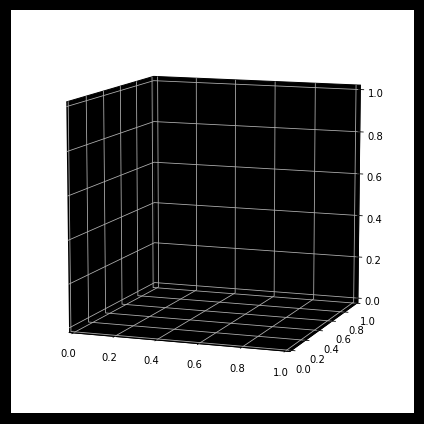

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
import numpy as np
from matplotlib import pyplot as plt
#%matplotlib notebook

%matplotlib inline
#clouds = np.load('/home/ammon/Documents/Scripts/deep-high-resolution-net.pytorch/demo/test_cloud.npy')
clouds = np.load('/data/birds/postures/birdview2-2019/2019-05-30-15-33-06_2M/cloud_3d.npy')

#print(np.shape(clouds))

#fig = plt.figure()
#ax = fig.add_subplot(111,projection='3d')
f = 80
f_start = 0
f_stop = len(clouds[f])
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
for f in range(f_start,f_stop):
    ax.clear()
    cloud_array = clouds[f]
    #cloud_array = np.array(clouds[f])

    #cloud_array = cloud_array[~np.isnan(cloud_array)]
    color_map = cm.get_cmap('viridis')
    z_max,z_min = np.nanmax(cloud_array[:,2]),np.nanmin(cloud_array[:,2])
    z_range = z_max - z_min

    clip_points = np.load('/data/birds/postures/birdview2-2019/2019-05-30-15-33-06_2M/pred_keypoints_3d.npy')
    #clip_points = np.load('/home/ammon/Documents/Scripts/deep-high-resolution-net.pytorch/demo/test_3d.npy')
    clip_points = clip_points * 1000

    for p in range(len(cloud_array)):
        height_ratio = (cloud_array[p,2] - z_min) / z_range
        if np.isnan(cloud_array[p,0]):
            continue
        ax.scatter(cloud_array[p,0],cloud_array[p,1],cloud_array[p,2],color=color_map(height_ratio),alpha=.3,s=5,marker='s')


    for k in range(len(clip_points[f])-3):
        ax.scatter(clip_points[f,k,0],clip_points[f,k,1],clip_points[f,k,2],color='red')

    ax.w_xaxis.set_pane_color([0,0,0,1])
    ax.w_yaxis.set_pane_color([0,0,0,1])
    ax.w_zaxis.set_pane_color([0,0,0,1])

    ax.view_init(10, 290)

    ax.set_xlim([100,450])
    ax.set_ylim([0,350])
    ax.set_zlim([150,400])
    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    fig.tight_layout()
    fig.set_size_inches((6,6))
    fig.patch.set_facecolor('black')
    #fig.show()
    fig.savefig('/home/ammon/Desktop/PaperFigs/images2/point_cloud%04d.png'%f,dpi=300)

#fig.show()

In [16]:
print(clip_points.shape)
print(clouds[0])


(13, 17, 3)
[[227.5 157.5 267.5]
 [227.5 157.5 272.5]
 [227.5 157.5 277.5]
 ...
 [  nan   nan   nan]
 [  nan   nan   nan]
 [  nan   nan   nan]]


(13, 1916, 3)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


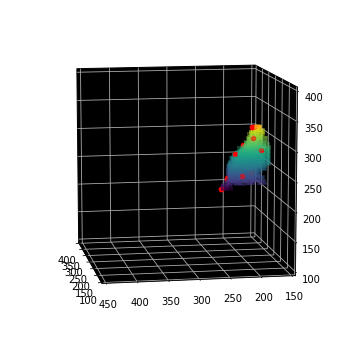

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
#%matplotlib notebook

%matplotlib inline
#clouds = np.load('/home/ammon/Documents/Scripts/deep-high-resolution-net.pytorch/demo/test_cloud.npy')
clouds = np.load('/home/ammon/Documents/Scripts/keypoint_detection/data_dir/2019-06-12-11-46-13_LNR_veryveryshort/cloud_3d.npy')


#print(np.shape(clouds))

fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
f = 10

cloud_array = clouds[f]
print(clouds.shape)
#cloud_array = np.array(clouds[f])

#cloud_array = cloud_array[~np.isnan(cloud_array)]
color_map = cm.get_cmap('viridis')
z_max,z_min = np.nanmax(cloud_array[:,2]),np.nanmin(cloud_array[:,2])
z_range = z_max - z_min

clip_points = np.load('/home/ammon/Documents/Scripts/keypoint_detection/data_dir/2019-06-12-11-46-13_LNR_veryveryshort/pred_keypoints_3d.npy')
#clip_points = np.load('/home/ammon/Documents/Scripts/deep-high-resolution-net.pytorch/demo/test_3d.npy')
clip_points = clip_points * 1000

for p in range(len(cloud_array)):
    height_ratio = (cloud_array[p,2] - z_min) / z_range
    if np.isnan(cloud_array[p,0]):
        continue
    ax.scatter(cloud_array[p,0],cloud_array[p,1],cloud_array[p,2],color=color_map(height_ratio),alpha=.3,s=5,marker='s')


for k in range(len(clip_points[f])):
    ax.scatter(clip_points[f,k,0],clip_points[f,k,1],clip_points[f,k,2],color='red')
    
ax.w_xaxis.set_pane_color([0,0,0,1])
ax.w_yaxis.set_pane_color([0,0,0,1])
ax.w_zaxis.set_pane_color([0,0,0,1])

ax.view_init(10, 170)

ax.set_xlim([100,400])
ax.set_ylim([150,450])
ax.set_zlim([100,400])

fig.set_size_inches((6,6))
fig.savefig('/home/ammon/Desktop/PaperFigs/point_cloud_blank.png',dpi=300)
fig.show()


In [312]:
ax.set_xlim([100,400])
ax.set_ylim([100,400])
ax.set_zlim([100,400])

fig.set_size_inches((6,6))
#fig.savefig('/home/ammon/Desktop/PaperFigs/point_cloud_blank.png',dpi=300)
fig.show()

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [308]:
print(z_range,z_min,z_max)

nan nan 312.5


In [304]:
cloud_array.shape

(197, 2147, 3)

In [29]:
clip_points = np.load('./2019-06-24-11-46-15_BDY_clipped/pred_keypoints_3d.npy')
print(np.shape(clip_points))

(6, 20, 3)


In [118]:
from sklearn.decomposition import PCA
pca_points = PCA()
pca_points.fit(np.array(clouds[300]))
print(np.round(pca_points.explained_variance_ratio_,2))
output = pca_points.components_[:2]
print('5' + str(output.flatten()).replace('[','').replace(' ',',').replace(']',''))

[0.64 0.21 0.14]
5,0.38700851,-0.65667147,-0.64730749,-0.37713039,,0.52788199,-0.76099492


In [48]:
import cv2

cap = cv2.VideoCapture('/data/birds/postures/birdview-2019/2019-06-28-11-46-14_WG.wav.mp4')

while(1):
    ret,frame = cap.read()
    print(ret)
    if not ret:
        print('Done!')
        break

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [78]:
test2 = np.load('./2019-06-12-11-46-13_LNR_veryveryshort/pred_keypoints_3d.npy')

print(np.shape(test_3d))
print(np.shape(test2))
print(test_3d[0])
print(test2[0])


(20, 3, 13)
(20, 3, 13)
[[205. 245. 205. 425. 495. 205. 195. 225. 225. 225. 235. 225. 225.]
 [355. 185. 375. 135. 115. 385. 495. 195. 195. 195. 255. 455. 455.]
 [375. 325. 385. 375. 395. 385. 425. 325. 325. 325. 315. 425. 425.]]
[[220.5 220.5 300.5 220.5 300.5 340.5 300.5 300.5 320.5 340.5 300.5 320.5
  320.5]
 [200.5 200.5 200.5 200.5 200.5 220.5 200.5 200.5 200.5 220.5 200.5 220.5
  220.5]
 [320.5 320.5 300.5 320.5 300.5 285.5 300.5 300.5 300.5 300.5 300.5 240.5
  240.5]]


(679, 20, 3)


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


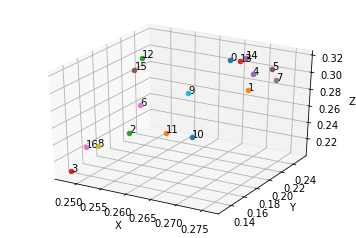

In [26]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 

%matplotlib inline

#sequence = np.load('../keypoint_detection/data_dir/2019-06-12-11-46-13_LNR_veryveryshort/pred_keypoints_3d.npy')
sequence = np.load('/data/birds/postures/birdview-2018/2018-05-30-11-17-56_DMG/pred_keypoints_3d.npy')
print(sequence.shape)
test2 = sequence[0]
fig1 = plt.figure()
ax1 = fig1.add_subplot(111,projection='3d')

f = 230
for p in range(17):
    ax1.scatter(test2[p,0],test2[p,1],test2[p,2])
    ax1.text(test2[p,0],test2[p,1],test2[p,2],str(p))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

fig1.show()

(4, 17, 3, 990)
nan
0.059374269072523876


/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


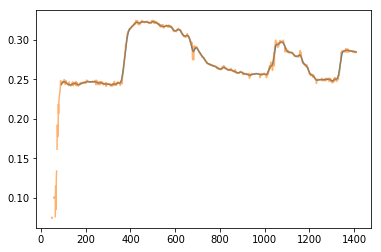

In [49]:
from scipy.ndimage import gaussian_filter1d


fig,ax = plt.subplots()
#sequence = np.load('../keypoint_detection/data_dir/2019-06-12-11-46-13_LNR_veryveryshort/pred_keypoints_3d.npy')
#sequence = np.load('/data/birds/postures/birdview2-2019/2019-06-26-08-34-11_BDY/pred_keypoints_3d.npy')
sequence = np.load('/data/birds/postures/birdview-2018/2018-06-01-09-48-06/pred_keypoints_3d.npy')
#sequence_2d = np.load('/data/birds/postures/birdview-2018/2018-05-30-14-18-02_LB-/pred_keypoints_2d.npy')
#sequence_2d = np.load('/data/birds/postures/birdview-2019/2019-06-03-07-19-01_BOD/pred_keypoints_2d.npy')
print(sequence_2d.shape)
for s in range(4):    
    #ax.plot(sequence_2d[s,10,1])
    pass
fig.show()
ax.plot(gaussian_filter1d(sequence[:,10,2],5))
ax.plot(sequence[:,10,2],alpha=.6)
#print(np.unique(~np.isnan(sequence[:,10,2])))

print(np.min(sequence))
print(np.nanmin(sequence))

<IPython.core.display.Javascript object>


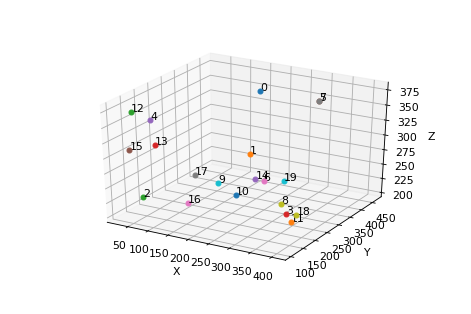

In [87]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

f = 0
for p in range(20):
    ax.scatter(test_3d[p,0,f],test_3d[p,1,f],test_3d[p,2,f])
    ax.text(test_3d[p,0,f],test_3d[p,1,f],test_3d[p,2,f],str(p))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

fig.show()

In [65]:
tuple([50] * 3)

(50, 50, 50)

In [76]:
import itertools
all_points = np.array(list(itertools.product(np.arange(0,500,5),np.arange(0,500,5),np.arange(0,500,5))))
hom_points = np.ones([len(all_points),4])
hom_points[:,:3] = all_points / 1000
print(all_points,hom_points)

P_c = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
print(P_c.shape)
np.dot()

[[  0   0   0]
 [  0   0   5]
 [  0   0  10]
 ...
 [495 495 485]
 [495 495 490]
 [495 495 495]] [[0.    0.    0.    1.   ]
 [0.    0.    0.005 1.   ]
 [0.    0.    0.01  1.   ]
 ...
 [0.495 0.495 0.485 1.   ]
 [0.495 0.495 0.49  1.   ]
 [0.495 0.495 0.495 1.   ]]


In [89]:
for i in range(10):
    for j in range(10):
        break
    print(i)

0
1
2
3
4
5
6
7
8
9


In [100]:
np.unique(all_points,axis=0)

array([[  0,   0,   0],
       [  0,   0,   5],
       [  0,   0,  10],
       ...,
       [495, 495, 485],
       [495, 495, 490],
       [495, 495, 495]])

In [ ]:
import cv2
  
capture = cv2.VideoCapture('/data/birds/postures/TrainingPostures/bv-2019/2019-06-10-07-16-13_ND_clipped.mp4')
  
while(True):
      
    ret, frame = capture.read()
 
    grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
 
    cv2.imshow('video gray', grayFrame)
    cv2.imshow('video original', frame)
      
    if cv2.waitKey(1) == 27:
        break

capture.release()
cv2.destroyAllWindows()

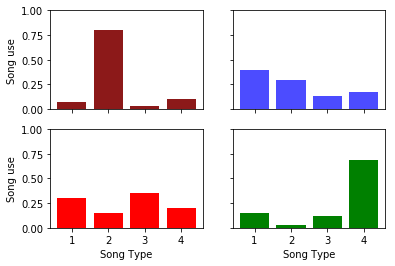

In [82]:
sample_data0 = [.30,.15,.35,.2]
sample_data1 = [.4,.3,.13,.17]
sample_data2 = [.07,.8,.03,.1]
sample_data3 = [.15,.03,.12,.69]

fig,axes = plt.subplots(2,2,sharey=True,sharex=True)
axes[1,0].bar(np.arange(1,5),sample_data0,color='red',label='Dominant Male')
axes[0,1].bar(np.arange(1,5),sample_data1,color='blue',alpha = .7,label='Pair Female')
axes[0,0].bar(np.arange(1,5),sample_data2,color='maroon',alpha=.9,label='Subordinant Male')
axes[1,1].bar(np.arange(1,5),sample_data3,color='green',label='Other Female')

axes[0,0].set_ylim(0,1)
axes[0,0].set_ylabel('Song use')
axes[1,0].set_xlabel('Song Type')
axes[1,0].set_ylabel('Song use')
axes[1,1].set_xlabel('Song Type')



fig.savefig('/home/ammon/Desktop/PaperFigs/fake_aviary.png',dpi=300)

/home/ammon/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


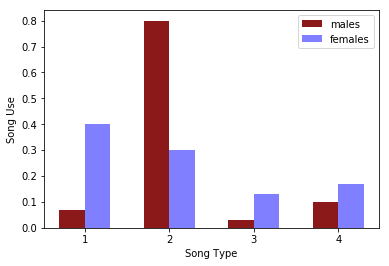

In [85]:
fig, ax = plt.subplots()
ax.bar(np.arange(1,5) - .15,sample_data2,color='maroon',alpha=.9,width=.3,label='males')
ax.bar(np.arange(1,5) +  .15,sample_data1,color='blue',alpha=.5,width=.3,label='females')
ax.set_xticks([1,2,3,4])
ax.set_xticklabels([1,2,3,4])
ax.set_xlabel('Song Type')
ax.set_ylabel('Song Use')
ax.legend()
fig.show()
fig.savefig('/home/ammon/Desktop/PaperFigs/fake_aviary2.png',dpi=300)